In [ ]:
# 1. Пройдем авторизацию, загрузим необходимые библиотеки и авторизуемся
from google.colab import drive
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import json
import numpy as np
import scipy.stats as stats

print('Библиотеки импортированы')

# 2. Получим доступ к файлу
drive.mount('/content/drive')

# 3. Загрузим файл
main_tab = pd.read_csv('/content/drive/MyDrive/Google_colab/onboarding_15_12.csv', dtype=str)

# 4. Преобразуем данные в колонках в необходимый формат
main_tab["event_json"] = main_tab["event_json"].fillna('{}')
main_tab['event_datetime'] = pd.to_datetime(main_tab.event_datetime, dayfirst=False)

# 5. Распакуем JSON-строки в отдельные колонки
json = pd.json_normalize(main_tab["event_json"].apply(json.loads))

# 6. Соединим исходный DataFrame с распакованными колонками
main_tab = pd.concat([main_tab.drop(columns=["event_json"]), json], axis=1)

# 7. Оствим только необходимые события и столбцы, а также исключим внутрненние аккаунты
main_tab = main_tab[['profile_id','session_id','appmetrica_device_id',
                     'os_name','event_name','event_datetime',
                     'space', 'section', 'screen_name',
                     'object', 'object_name','invite']]

main_tab = main_tab.query('space == "onboarding"')

main_tab = main_tab.query('profile_id != ["1", "37", "337", "521", \
                                          "1689", "8768", "14633", \
                                          "15208", "16019", "9919378"]')

# 8. Исключим тестовые аккаунты
main_tab = main_tab.query('appmetrica_device_id != ["9285600464782869245", "10032651443997849121","10259622646801123664", "3556494291664016194", \
                                                    "3809392268736845663", "8893078513773311408","4956997221218173730", "6851918540449290513", \
                                                    "15379619461355576665", "16765044760237514010","9334028275552938752", "10105559591254434151", \
                                                    "17287030721186854774", "7544771878415337443","17987955957707071981", \
                                                    "3955153233771396849","18254280579400659973"]'
                         )

# 9. Преобразуем колонку profile_id
main_tab.loc[:, "profile_id"] = main_tab["profile_id"].str.extract(r'(\d+)', expand=False)

print('Датафрейм сформирован и доступен к работе')

# 10. Сформируем датафрейм с пользователями, для которые событие просмотра первого экрана было первым >= '2024-11-14' (передается параметр invite)

registration_first_view_tab = main_tab.copy()

registration_first_view_tab = registration_first_view_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])

registration_first_view_tab['event_order'] = registration_first_view_tab.groupby('appmetrica_device_id').cumcount()+1

registration_first_view_tab = registration_first_view_tab[registration_first_view_tab['event_order'] == 1]

registration_first_view_tab = registration_first_view_tab.query('event_name == "view"') \
                                                 .query('section == "hello"') \
                                                 .query('screen_name == "first_screen"') \
                                                 .query('object == "screen"') \

# переменная, в которой дата, по которой будут отфильтрованы пользователи, которые первый раз посмотрели первый экран приложения
filter_date_registration_first_view_tab = pd.to_datetime('2024-11-14')


registration_first_view_tab = registration_first_view_tab[registration_first_view_tab['event_datetime'] >= filter_date_registration_first_view_tab]

# 11. Сформируем датафрейм со всеми событиями по пользователям, у которых регистрация была не раньше нужной даты

registration_users_tab = main_tab.copy()
registration_users_tab = registration_users_tab[registration_users_tab['appmetrica_device_id']
                                               .isin(registration_first_view_tab['appmetrica_device_id'])]

registration_users_tab = registration_users_tab.drop('invite', axis=1)
registration_users_tab = registration_users_tab.drop('profile_id', axis=1)

# 12 Сформируем таблицу, где каждому appmetrica_device_id присвоим первый profile_id
users_profile_id = main_tab.copy()
users_profile_id = users_profile_id.drop(['session_id', 'os_name', 'event_name',
                                          'space', 'section', 'screen_name',
                                          'object', 'object_name', 'invite'], axis=1) # 85193 rows

users_profile_id = users_profile_id.sort_values(['appmetrica_device_id', 'event_datetime'])
users_profile_id = users_profile_id.groupby('appmetrica_device_id')['profile_id'].first().reset_index()

# 85193
# 13 Присоеденим к таблице регистрациями столбец profile_id
registration_users_tab = registration_users_tab.merge(users_profile_id[['appmetrica_device_id', 'profile_id']], how='left', on='appmetrica_device_id')

# 14 Присоеденим к таблице регистрациями столбец invite
filtered_df = main_tab.copy()
filtered_df = filtered_df[filtered_df['invite'].notna()]
filtered_df = filtered_df.drop(['session_id', 'os_name', 'event_name', 'space',
                                'section', 'screen_name', 'object',
                                'object_name', 'appmetrica_device_id'], axis=1)

filtered_df = filtered_df.sort_values(['profile_id', 'event_datetime'])
filtered_df = filtered_df.drop_duplicates(subset='profile_id', keep='last')

registration_users_tab = registration_users_tab.merge(filtered_df[['profile_id', 'invite']], how='left', on='profile_id')

# 15 Добавим столбец, где будет присвоен статус приглашению
registration_users_tab['invite_status'] = registration_users_tab['invite'].apply(
    lambda x: 'empty' if pd.isna(x) else ('default' if x == 'default' else ('undefined' if x == 'undefined' else 'invite'))
    )

main_tab = registration_users_tab.copy()

Библиотеки импортированы
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Датафрейм сформирован и доступен к работе


In [ ]:
#### Сформируем датафрейм только с пользователями, которые по приглашению

#main_invite_tab = main_tab.copy()
#users_invite_tab = main_tab.copy()

#users_invite_tab['invite_status'] = users_invite_tab['invite_status'].fillna('empty')
#users_invite_tab = users_invite_tab.query('invite_status != "default"') \
#                                .query('invite_status != "empty"') \
#                                ['appmetrica_device_id'].unique()

#main_invite_tab = main_invite_tab[main_invite_tab['appmetrica_device_id'].isin(users_invite_tab)]

#main_tab = main_invite_tab.copy()

In [ ]:
#### (Индекс 1)

# 16 Расчитаем конверсию в действия на первом экране

# 16.1 Выделим пользователей, посмотревших первый экран
view_hello_tab = main_tab.copy()
view_hello_tab = view_hello_tab.query('event_name =="view"') \
                               .query('screen_name == "first_screen"') \


# 16.2 Выделим пользователей, нажавших на кнопку регистрации
choose_hello_registration_tab = main_tab.copy()
choose_hello_registration_tab = choose_hello_registration_tab.query('event_name == "choose"') \
                                                             .query('screen_name =="first_screen"') \
                                                             .query('object == "button"') \
                                                             .query('object_name == "registration_start"') \

# 16.3 Выделим пользователей, нажавших на кнопку преимуществ
choose_hello_features_tab = main_tab.copy()
choose_hello_features_tab = choose_hello_features_tab.query('event_name == "choose"') \
                                                     .query('screen_name =="first_screen"') \
                                                     .query('object == "button"') \
                                                     .query('object_name == "onboard_start"') \

# 16.4 Исключим из каждой выборки, пользователей, которые есть в других выборках

# Просмотр экрана
view_hello_tab = pd.concat(
    [view_hello_tab, choose_hello_registration_tab, choose_hello_features_tab],
    axis=0,
    ignore_index=True)

view_hello_tab = view_hello_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
view_hello_tab['rank'] = view_hello_tab.groupby('appmetrica_device_id').cumcount() + 1
view_hello_tab = view_hello_tab.query('event_name == "view"') \
                               .query('screen_name == "first_screen"') \
                               .query('rank == 1')


view_hello = view_hello_tab.appmetrica_device_id.nunique()

# Нажатие Регистрации

choose_hello_registration_tab = pd.concat(
    [choose_hello_registration_tab, choose_hello_features_tab],
    axis=0,
    ignore_index=True)

choose_hello_registration_tab = choose_hello_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
choose_hello_registration_tab['rank'] = choose_hello_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
choose_hello_registration_tab = choose_hello_registration_tab.query('event_name == "choose"') \
                                                             .query('screen_name == "first_screen"') \
                                                             .query('object == "button"') \
                                                             .query('object_name == "registration_start"') \
                                                             .query('rank == 1') \

# Нажатие Преимуществ

choose_hello_features_tab = pd.concat(
    [choose_hello_registration_tab, choose_hello_features_tab],
    axis=0,
    ignore_index=True)

choose_hello_features_tab = choose_hello_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
choose_hello_features_tab['rank'] = choose_hello_features_tab.groupby('appmetrica_device_id').cumcount() + 1
choose_hello_features_tab = choose_hello_features_tab.query('event_name == "choose"') \
                                                     .query('screen_name =="first_screen"') \
                                                     .query('object == "button"') \
                                                     .query('object_name == "onboard_start"') \
                                                     .query('rank == 1') \

# 16.5 Расчитаем конверсию в каждое действие
choose_hello_registration = choose_hello_registration_tab.appmetrica_device_id.nunique()
choose_hello_features = choose_hello_features_tab.appmetrica_device_id.nunique()

# 16.6 Рассчитаем конверсию в нажатие кнопки прохождения регистрации из просмотра первого экрана
conversion_rate_registration = round(choose_hello_registration * 100 / view_hello, 2)
# 16.7 Рассчитаем конверсию в нажатие кнопки просмотра преимуществ из просмотра первого экрана
conversion_rate_features = round(choose_hello_features * 100 / view_hello, 2)

# Потеря пользователей
lost_view_hello = view_hello - (choose_hello_registration + choose_hello_features )

print("Индекс 1")
print()
print(f"Общее число пользователей, просмотревших первый экран: {view_hello}")
print()
print("Регистрация")
print(f"Общее число пользователей, нажавших кнопку Регистрация: {choose_hello_registration}")
print(f"Конверсия в прохождение регистрации: {conversion_rate_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, нажавших кнопку Преимущества: {choose_hello_features}")
print(f"Конверсия в просмотр преимуществ: {conversion_rate_features:.2f}%")

Индекс 1

Общее число пользователей, просмотревших первый экран: 3908

Регистрация
Общее число пользователей, нажавших кнопку Регистрация: 2620
Конверсия в прохождение регистрации: 67.04%

Преимущества
Общее число пользователей, нажавших кнопку Преимущества: 946
Конверсия в просмотр преимуществ: 24.21%


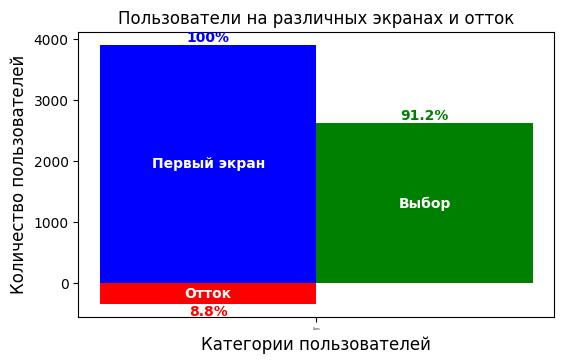

In [ ]:
#### (Индекс 1) ОТТОК

lost_view_hello = view_hello - (choose_hello_registration + choose_hello_features )
choose_hello_features

# Рассчитываем проценты относительно view_hello
choose_hello_registration_percent = ((choose_hello_registration + choose_hello_features) / view_hello) * 100
lost_view_hello_percent = (lost_view_hello / view_hello) * 100

# Создаём график
fig, ax = plt.subplots(figsize=(6, 4))

# Места для столбцов
bar_width = 0.1
index = [0]  # Местоположение для одного столбца

# Строим столбцы
view_hello_bar = ax.bar(index, view_hello, bar_width, label='view_hello (100%)', color='blue')  # Столбец view_hello
lost_view_hello_bar = ax.bar(index, -lost_view_hello, bar_width, label='lost_view_hello', color='red')  # Столбец lost_view_hello
choose_hello_registration_bar = ax.bar([i + bar_width for i in index], choose_hello_registration,
                                       bar_width, label='choose_hello_registration', color='green')  # Столбец choose_hello_registration

# Добавляем проценты и названия внутри каждого столбца
for i in index:
    # Добавляем текст для view_hello
    ax.text(i, view_hello / 2, 'Первый экран', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для view_hello
    ax.text(i, view_hello + 5, f'100%', ha='center', va='bottom', color='blue', fontweight='bold', fontsize=10)

    # Добавляем текст для lost_view_hello
    ax.text(i, -lost_view_hello / 2, 'Отток', ha='center', va='center', color='white', fontsize=10, fontweight='bold')  # Название в центре столбца

    # Процент для lost_view_hello
    ax.text(i, -lost_view_hello - 5, f'{lost_view_hello_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для choose_hello_registration
    ax.text(i + bar_width, choose_hello_registration / 2, 'Выбор', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для choose_hello_registration
    ax.text(i + bar_width, choose_hello_registration + 5, f'{choose_hello_registration_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

# Настройка осей
ax.set_xlabel('Категории пользователей', fontsize=12)  # Уменьшаем шрифт для оси X
ax.set_ylabel('Количество пользователей', fontsize=12)  # Уменьшаем шрифт для оси Y
ax.set_title('Пользователи на различных экранах и отток', fontsize=12)  # Уменьшаем размер шрифта для заголовка

# Устанавливаем метки на оси X
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Users'], fontsize=2)

# Настройка tight_layout для автоматической подгонки
plt.tight_layout(pad=2.0)

# Показываем график
plt.show()


In [ ]:
#### (Индекс 4,6,8)

# 17.1 Расчитаем конверсию в просмотр экранов преимуществ

# 17.2 Выделим пользователей, нажавших Далее на первом экране преимуществ (Индекс 1)
view_features_1_tab = main_tab.copy()
view_features_1_tab = view_features_1_tab.query('event_name == "click"') \
                                         .query('section == "features"') \
                                         .query('screen_name =="features_1"') \
                                         .query('object == "button"') \
                                         .query('object_name == "next"') \

view_features_1_tab = view_features_1_tab[view_features_1_tab['appmetrica_device_id']
                                          .isin(choose_hello_features_tab ['appmetrica_device_id'])]


view_features_1 = view_features_1_tab.appmetrica_device_id.nunique()

# 17.3 Выделим пользователей, нажавших Далее на втором экране преимуществ (Индекс 2)
view_features_2_tab = main_tab.copy()
view_features_2_tab = view_features_2_tab.query('event_name == "click"') \
                                         .query('section == "features"') \
                                         .query('screen_name =="features_2"') \
                                         .query('object == "button"') \
                                         .query('object_name == "next"') \

view_features_2_tab = view_features_2_tab[view_features_2_tab['appmetrica_device_id']
                                         .isin(view_features_1_tab['appmetrica_device_id'])]

view_features_2 = view_features_2_tab.appmetrica_device_id.nunique()

# 17.4 Выделим пользователей, нажавших Далее на третием экране преимуществ (Индекс 3)
view_features_3_tab = main_tab.copy()
view_features_3_tab = view_features_3_tab.query('event_name == "click"') \
                                         .query('section == "features"') \
                                         .query('screen_name =="features_3"') \
                                         .query('object == "button"') \
                                         .query('object_name == "next"') \

view_features_3_tab = view_features_3_tab[view_features_3_tab['appmetrica_device_id']
                                         .isin(view_features_2_tab['appmetrica_device_id'])]

view_features_3 = view_features_3_tab.appmetrica_device_id.nunique()

# 17.5 Рассчитаем конверсию в нажатие Далее на 1-ом экране
conversion_rate_features_1 = round(view_features_1 * 100 / view_hello, 2)

# 17.6 Рассчитаем конверсию в нажатие Далее на 2-ом экране
conversion_rate_features_2 = round(view_features_2 * 100 / view_hello, 2)

# 17.7 Рассчитаем конверсию в нажатие Далее на 3-ем экране
conversion_rate_features_3 = round(view_features_3 * 100 / view_hello, 2)

# Потеря пользователей
lost_view_features_1 = choose_hello_features - view_features_1
lost_view_features_2 = view_features_1 - view_features_2


print("Индекс 4, 6, 8")
print()
print(f"Общее число пользователей, просмотревших первый экран: {view_hello}")
print(f"Общее число пользователей, нажавших кнопку Регистрация: {choose_hello_registration}")
print(f"Общее число пользователей, нажавших кнопку Преимущества: {choose_hello_features}")
print()
print(f"Общее число пользователей, кликнувших кнопку далее на первом экране преимуществ: {view_features_1}")
print(f"Конверсия в клик по далее на первом экране преимуществ: {conversion_rate_features_1:.2f}%")
print()
print(f"Общее число пользователей, кликнувших кнопку далее на втором экране преимуществ:: {view_features_2}")
print(f"Конверсия в клик по далее на втором экране преимуществ:  {conversion_rate_features_2:.2f}%")
print()
print(f"Общее число пользователей, кликнувших кнопку далее на третьем экране преимуществ: {view_features_3}")
print(f"Конверсия в клик по далее на третьем экране преимуществ: {conversion_rate_features_3:.2f}%")

Индекс 4, 6, 8

Общее число пользователей, просмотревших первый экран: 3908
Общее число пользователей, нажавших кнопку Регистрация: 2620
Общее число пользователей, нажавших кнопку Преимущества: 946

Общее число пользователей, кликнувших кнопку далее на первом экране преимуществ: 920
Конверсия в клик по далее на первом экране преимуществ: 23.54%

Общее число пользователей, кликнувших кнопку далее на втором экране преимуществ:: 862
Конверсия в клик по далее на втором экране преимуществ:  22.06%

Общее число пользователей, кликнувших кнопку далее на третьем экране преимуществ: 820
Конверсия в клик по далее на третьем экране преимуществ: 20.98%


In [ ]:
#### (Индекс 29) Регистрация

# 18.1 Расчитаем конверсию в регистрацию отдельно по тем, кто нажал на регистрацию, и кто смотрел преимущества

# 18.2 Выделим тех, кто посмотрел экран успешной регистрации

view_discover_app_tab = main_tab.copy()
view_discover_app_tab = view_discover_app_tab.query('event_name == "view"') \
                                             .query('section == "discover_app"') \
                                             .query('screen_name =="registration_complete_screen"') \
                                             .query('object == "screen"') \


# 18.3 Оставим среди завершивших регистрацию тех, кто выбрал Преимущества

view_discover_app_features_tab = view_discover_app_tab.copy()

view_discover_app_features_tab = view_discover_app_features_tab[view_discover_app_features_tab['appmetrica_device_id']
                                                              .isin(view_features_3_tab['appmetrica_device_id'])]

view_discover_app_features = view_discover_app_features_tab.appmetrica_device_id.nunique()

conversion_rate_features_view_discover_app_features = round(view_discover_app_features * 100 / view_hello, 2)


# 18.4 Оставим среди завершивших регистрацию тех, кто выбрал Регистрация

view_discover_app_registration_tab = view_discover_app_tab.copy()

view_discover_app_registration_tab = view_discover_app_registration_tab[view_discover_app_registration_tab['appmetrica_device_id']
                                                                  .isin(choose_hello_registration_tab['appmetrica_device_id'])]

view_discover_app_registration = view_discover_app_registration_tab.appmetrica_device_id.nunique()
conversion_rate_registration_view_discover_app_registration = round(view_discover_app_registration * 100 / view_hello, 2)

print("Индекс 29 Регистрация")
print()
print(f"Общее число пользователей, просмотревших первый экран: {view_hello}")
print(f"Общее число пользователей, выбравших на 1-ом экране перейти к регистрации: {choose_hello_registration}")
print(f"Общее число пользователей, выбравших на 1-ом экране перейти к преимуществам: {choose_hello_features}")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших на 1-ом экране Регистрация и зарегистрировавшихся: {view_discover_app_registration}")
print(f"Конверсия в регистрацию их тех, кто выбрал Регистрация: {conversion_rate_registration_view_discover_app_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, выбравших на 1-ом экране Преимущества и зарегистрировавшихся: {view_discover_app_features}")
print(f"Конверсия в регистрацию их тех, кто выбрал Преимущества: {conversion_rate_features_view_discover_app_features:.2f}%")

Индекс 29 Регистрация

Общее число пользователей, просмотревших первый экран: 3908
Общее число пользователей, выбравших на 1-ом экране перейти к регистрации: 2620
Общее число пользователей, выбравших на 1-ом экране перейти к преимуществам: 946

Регистрация
Общее число пользователей, выбравших на 1-ом экране Регистрация и зарегистрировавшихся: 1900
Конверсия в регистрацию их тех, кто выбрал Регистрация: 48.62%

Преимущества
Общее число пользователей, выбравших на 1-ом экране Преимущества и зарегистрировавшихся: 395
Конверсия в регистрацию их тех, кто выбрал Преимущества: 10.11%


In [ ]:
#### (Индекс 29) Переход в приложение и в Изучение приложения

# 19.1 Таблица с теми, кто перешел в приложение
choose_discover_app_go_tab = main_tab.copy()
choose_discover_app_go_tab = choose_discover_app_go_tab.query('event_name == "choose"') \
                                                       .query('section == "discover_app"') \
                                                       .query('screen_name =="registration_complete_screen"') \
                                                       .query('object == "button"') \
                                                       .query('object_name == "app_go"') \

# 19.2 Таблица с теми, кто продолжил изучать онбординг
choose_discover_app_explorer = main_tab.copy()
choose_discover_app_explorer = choose_discover_app_explorer.query('event_name == "click"') \
                                                           .query('section == "discover_app"') \
                                                           .query('screen_name =="registration_complete_screen"') \
                                                           .query('object == "button"') \
                                                           .query('object_name == "app_explore"') \

# 19.3 Выделим тех, кто выбрал Регистрация

# 19.3.1 Выбрали Перейти в приложение
choose_discover_app_go_registration_tab = choose_discover_app_go_tab.copy()
choose_discover_app_go_registration_tab = choose_discover_app_go_registration_tab[choose_discover_app_go_registration_tab['appmetrica_device_id']
                                                                                 .isin(view_discover_app_registration_tab['appmetrica_device_id'])]
# 19.3.2 Выбрали Изучать приложение
choose_discover_app_explorer_registration_tab = choose_discover_app_explorer.copy()
choose_discover_app_explorer_registration_tab = choose_discover_app_explorer_registration_tab[choose_discover_app_explorer_registration_tab['appmetrica_device_id']
                                                                                             .isin(view_discover_app_registration_tab['appmetrica_device_id'])]

# 19.4 Выделим тех, кто выбрал Преимущества

choose_discover_app_go_features_tab = choose_discover_app_go_tab.copy()
choose_discover_app_go_features_tab = choose_discover_app_go_features_tab[choose_discover_app_go_features_tab['appmetrica_device_id']
                                                                         .isin(view_discover_app_features_tab['appmetrica_device_id'])]
# 19.3.2 Выбрали Изучать приложение
choose_discover_app_explorer_features_tab = choose_discover_app_explorer.copy()
choose_discover_app_explorer_features_tab = choose_discover_app_explorer_features_tab[choose_discover_app_explorer_features_tab['appmetrica_device_id']
                                                                                     .isin(view_discover_app_features_tab['appmetrica_device_id'])]

# 19.7 Исключим из каждой выборки, пользователей, которые есть в других выборках

# 19.7.1 Регистрация: Переход в Приложение и Онбординг

choose_discover_app_go_registration_tab = pd.concat(
    [choose_discover_app_go_registration_tab, choose_discover_app_explorer_registration_tab],
    axis=0,
    ignore_index=True)

choose_discover_app_go_registration_tab = choose_discover_app_go_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
choose_discover_app_go_registration_tab['rank'] = choose_discover_app_go_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
choose_discover_app_go_registration_tab = choose_discover_app_go_registration_tab.query('event_name == "choose"') \
                                                                                .query('section == "discover_app"') \
                                                                                .query('screen_name =="registration_complete_screen"') \
                                                                                .query('object == "button"') \
                                                                                .query('object_name == "app_go"') \
                                                                                .query('rank == 1') \

choose_discover_app_explorer_registration_tab = pd.concat(
    [choose_discover_app_go_registration_tab, choose_discover_app_explorer_registration_tab],
    axis=0,
    ignore_index=True)

choose_discover_app_explorer_registration_tab = choose_discover_app_explorer_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
choose_discover_app_explorer_registration_tab['rank'] = choose_discover_app_explorer_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
choose_discover_app_explorer_registration_tab = choose_discover_app_explorer_registration_tab.query('event_name == "click"') \
                                                                                             .query('section == "discover_app"') \
                                                                                             .query('screen_name =="registration_complete_screen"') \
                                                                                             .query('object == "button"') \
                                                                                             .query('object_name == "app_explore"') \
                                                                                             .query('rank == 1') \

# 19.7.2  Преимущества: Переход в Приложение и Онбординг

choose_discover_app_go_features_tab = pd.concat(
    [choose_discover_app_go_features_tab, choose_discover_app_explorer_features_tab],
    axis=0,
    ignore_index=True)

choose_discover_app_go_features_tab = choose_discover_app_go_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
choose_discover_app_go_features_tab['rank'] = choose_discover_app_go_features_tab.groupby('appmetrica_device_id').cumcount() + 1
choose_discover_app_go_features_tab = choose_discover_app_go_features_tab.query('event_name == "choose"') \
                                                                         .query('section == "discover_app"') \
                                                                         .query('screen_name =="registration_complete_screen"') \
                                                                         .query('object == "button"') \
                                                                         .query('object_name == "app_go"') \
                                                                         .query('rank == 1') \

choose_discover_app_explorer_features_tab = pd.concat(
    [choose_discover_app_go_features_tab, choose_discover_app_explorer_features_tab],
    axis=0,
    ignore_index=True)

choose_discover_app_explorer_features_tab = choose_discover_app_explorer_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
choose_discover_app_explorer_features_tab['rank'] = choose_discover_app_explorer_features_tab.groupby('appmetrica_device_id').cumcount() + 1
choose_discover_app_explorer_features_tab = choose_discover_app_explorer_features_tab.query('event_name == "click"') \
                                                                                     .query('section == "discover_app"') \
                                                                                     .query('screen_name =="registration_complete_screen"') \
                                                                                     .query('object == "button"') \
                                                                                     .query('object_name == "app_explore"') \
                                                                                     .query('rank == 1') \

## 19.8 Рассчитаем показатели конверсии по тем, кто перешел в приложение

# Преимущества
choose_discover_app_go_features = choose_discover_app_go_features_tab.appmetrica_device_id.nunique()
conversion_rate_choose_discover_app_go_features = round(choose_discover_app_go_features * 100 / view_hello, 2)

# Регистрация
choose_discover_app_go_registration = choose_discover_app_go_registration_tab.appmetrica_device_id.nunique()
conversion_rate_choose_discover_app_go_registration = round(choose_discover_app_go_registration * 100 / view_hello, 2)

# # 19.9 Рассчитаем показатели конверсии по тем, кто перешел далее по онбордингу (Изучать приложение)

# Преимущества
choose_discover_app_explorer_features = choose_discover_app_explorer_features_tab.appmetrica_device_id.nunique()
conversion_rate_choose_discover_app_explorer_features = round(choose_discover_app_explorer_features * 100 / view_hello, 2)

# Регистрация
choose_discover_app_explorer_registration = choose_discover_app_explorer_registration_tab.appmetrica_device_id.nunique()
conversion_rate_choose_discover_app_explorer_registration = round(choose_discover_app_explorer_registration * 100 / view_hello, 2)

print("Индекс 29 Изучение приложения и Переход в приложение")
print()
print(f"Общее число пользователей, просмотревших первый экран: {view_hello}")
print(f"Общее число пользователей, выбравших на 1-ом экране перейти к регистрации: {choose_hello_registration}")
print(f"Общее число пользователей, выбравших на 1-ом экране перейти к преимуществам: {choose_hello_features}")
print()
print("Пользователи, перешедшие в приложение:")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших Регистрация и перешедших в приложение: {choose_discover_app_go_registration}")
print(f"Конверсия в переход в приложение, кто выбрал Регистрация: {conversion_rate_choose_discover_app_go_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, выбравших Преимущества и перешедших в приложение: {choose_discover_app_go_features}")
print(f"Конверсия в переход в приложение, кто выбрал Преимущества: {conversion_rate_choose_discover_app_go_features:.2f}%")
print()
print("Пользователи, перешедшие в Изучение приложения:")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших Регистрация и перешедших изучить приложение: {choose_discover_app_explorer_registration}")
print(f"Конверсия в изучить приложение, кто выбрал Регистрация: {conversion_rate_choose_discover_app_explorer_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, выбравших Преимущества и перешедших изучить приложение: {choose_discover_app_explorer_features}")
print(f"Конверсия в изучить приложение, кто выбрал Преимущества: {conversion_rate_choose_discover_app_explorer_features:.2f}%")

Индекс 29 Изучение приложения и Переход в приложение

Общее число пользователей, просмотревших первый экран: 3908
Общее число пользователей, выбравших на 1-ом экране перейти к регистрации: 2620
Общее число пользователей, выбравших на 1-ом экране перейти к преимуществам: 946

Пользователи, перешедшие в приложение:

Регистрация
Общее число пользователей, выбравших Регистрация и перешедших в приложение: 536
Конверсия в переход в приложение, кто выбрал Регистрация: 13.72%

Преимущества
Общее число пользователей, выбравших Преимущества и перешедших в приложение: 105
Конверсия в переход в приложение, кто выбрал Преимущества: 2.69%

Пользователи, перешедшие в Изучение приложения:

Регистрация
Общее число пользователей, выбравших Регистрация и перешедших изучить приложение: 1311
Конверсия в изучить приложение, кто выбрал Регистрация: 33.55%

Преимущества
Общее число пользователей, выбравших Преимущества и перешедших изучить приложение: 283
Конверсия в изучить приложение, кто выбрал Преимуществ

In [ ]:
#### (Индекс 32) Выбор роли Эксперт, Пользователь, Обе роли

# 20.1 Пользователи выбравшие Эксперт
click_role_way_expert = main_tab.copy()
click_role_way_expert = click_role_way_expert.query('event_name == "click"') \
                                             .query('section == "role_way"') \
                                             .query('screen_name =="role_selection"') \
                                             .query('object == "choose"') \
                                             .query('object_name == "expert_selected"') \

# 20.2 Пользователи выбравшие Пользователя
click_role_way_explorer = main_tab.copy()
click_role_way_explorer = click_role_way_explorer.query('event_name == "click"') \
                                                 .query('section == "role_way"') \
                                                 .query('screen_name =="role_selection"') \
                                                 .query('object == "choose"') \
                                                 .query('object_name == "explorer_selected"') \

# 20.3 Пользователи выбравшие Обе роли
click_role_way_both_role = main_tab.copy()
click_role_way_both_role = click_role_way_both_role.query('event_name == "click"') \
                                                   .query('section == "role_way"') \
                                                   .query('screen_name =="role_selection"') \
                                                   .query('object == "choose"') \
                                                   .query('object_name == "both_roles_selected"') \

# 20.4 Пользователи выбравшие Крестик
click_role_way_skip = main_tab.copy()
click_role_way_skip = click_role_way_skip.query('event_name == "click"') \
                                         .query('section == "role_way"') \
                                         .query('screen_name =="role_selection"') \
                                         .query('object == "button"') \
                                         .query('object_name == "role_selection_skip"') \

# 20.5 Выделим тех, выбрал Регистрацию

# 20.5.1 Выбрали Эксперта
click_role_way_expert_registration_tab = click_role_way_expert.copy()
click_role_way_expert_registration_tab = click_role_way_expert_registration_tab[click_role_way_expert_registration_tab['appmetrica_device_id']
                                                                               .isin(choose_discover_app_explorer_registration_tab['appmetrica_device_id'])]
# 20.5.2 Выбрали Пользователя
click_role_way_explorer_registration_tab = click_role_way_explorer.copy()
click_role_way_explorer_registration_tab = click_role_way_explorer_registration_tab[click_role_way_explorer_registration_tab['appmetrica_device_id']
                                                                                .isin(choose_discover_app_explorer_registration_tab['appmetrica_device_id'])]

# 20.5.3 Выбрали Обе роли
click_role_way_both_role_registration_tab = click_role_way_both_role.copy()
click_role_way_both_role_registration_tab = click_role_way_both_role_registration_tab[click_role_way_both_role_registration_tab['appmetrica_device_id']
                                                                                     .isin(choose_discover_app_explorer_registration_tab['appmetrica_device_id'])]

# 20.5.4 Выбрали Крестик
click_role_way_skip_registration_tab = click_role_way_skip.copy()
click_role_way_skip_registration_tab = click_role_way_skip_registration_tab[click_role_way_skip_registration_tab['appmetrica_device_id']
                                                                           .isin(choose_discover_app_explorer_registration_tab['appmetrica_device_id'])]

# 20.6 Выделим тех, выбрал Преимущества

# 20.6.1 Выбрали Эксперта
click_role_way_expert_features_tab = click_role_way_expert.copy()
click_role_way_expert_features_tab = click_role_way_expert_features_tab[click_role_way_expert_features_tab['appmetrica_device_id']
                                                                       .isin(choose_discover_app_explorer_features_tab['appmetrica_device_id'])]
# 20.6.2 Выбрали Пользователя
click_role_way_explorer_features_tab = click_role_way_explorer.copy()
click_role_way_explorer_features_tab = click_role_way_explorer_features_tab[click_role_way_explorer_features_tab['appmetrica_device_id']
                                                                           .isin(choose_discover_app_explorer_features_tab['appmetrica_device_id'])]

# 20.6.3 Выбрали Обе роли
click_role_way_both_role_features_tab = click_role_way_both_role.copy()
click_role_way_both_role_features_tab = click_role_way_both_role_features_tab[click_role_way_both_role_features_tab['appmetrica_device_id']
                                                                             .isin(choose_discover_app_explorer_features_tab['appmetrica_device_id'])]

# 20.6.4 Выбрали Крестик
click_role_way_skip_features_tab = click_role_way_skip.copy()
click_role_way_skip_features_tab = click_role_way_skip_features_tab[click_role_way_skip_features_tab['appmetrica_device_id']
                                                                   .isin(choose_discover_app_explorer_features_tab['appmetrica_device_id'])]



# 20.7 Исключим из каждой выборки, пользователей, которые есть в других выборках

# 20.7.1 Регистрация: Эксперт, Пользователь, Обе роли, Крестик

click_role_way_expert_registration_tab = pd.concat(
    [click_role_way_expert_registration_tab, click_role_way_explorer_registration_tab, click_role_way_both_role_registration_tab],
    axis=0,
    ignore_index=True)

click_role_way_expert_registration_tab = click_role_way_expert_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_expert_registration_tab['rank'] = click_role_way_expert_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_expert_registration_tab = click_role_way_expert_registration_tab.query('event_name == "click"') \
                                                                               .query('section == "role_way"') \
                                                                               .query('screen_name =="role_selection"') \
                                                                               .query('object == "choose"') \
                                                                               .query('object_name == "expert_selected"') \
                                                                               .query('rank == 1') \

click_role_way_explorer_registration_tab = pd.concat(
    [click_role_way_expert_registration_tab, click_role_way_explorer_registration_tab, click_role_way_both_role_registration_tab],
    axis=0,
    ignore_index=True)

click_role_way_explorer_registration_tab = click_role_way_explorer_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_explorer_registration_tab['rank'] = click_role_way_explorer_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_explorer_registration_tab = click_role_way_explorer_registration_tab.query('event_name == "click"') \
                                                                                   .query('section == "role_way"') \
                                                                                   .query('screen_name =="role_selection"') \
                                                                                   .query('object == "choose"') \
                                                                                   .query('object_name == "explorer_selected"') \
                                                                                   .query('rank == 1') \

click_role_way_both_role_registration_tab = pd.concat(
    [click_role_way_expert_registration_tab, click_role_way_explorer_registration_tab, click_role_way_both_role_registration_tab],
    axis=0,
    ignore_index=True)

click_role_way_both_role_registration_tab = click_role_way_both_role_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_both_role_registration_tab['rank'] = click_role_way_both_role_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_both_role_registration_tab = click_role_way_both_role_registration_tab.query('event_name == "click"') \
                                                                                     .query('section == "role_way"') \
                                                                                     .query('screen_name =="role_selection"') \
                                                                                     .query('object == "choose"') \
                                                                                     .query('object_name == "both_roles_selected"') \
                                                                                     .query('rank == 1') \

click_role_way_skip_registration_tab = pd.concat(
    [click_role_way_expert_registration_tab, click_role_way_explorer_registration_tab, click_role_way_both_role_registration_tab, click_role_way_skip_registration_tab],
    axis=0,
    ignore_index=True)

click_role_way_skip_registration_tab = click_role_way_skip_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_skip_registration_tab['rank'] = click_role_way_skip_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_skip_registration_tab = click_role_way_skip_registration_tab.query('event_name == "click"') \
                                                                           .query('section == "role_way"') \
                                                                           .query('screen_name =="role_selection"') \
                                                                           .query('object == "button"') \
                                                                           .query('object_name == "role_selection_skip"') \
                                                                           .query('rank == 1') \


# 20.7.2 Преимущества: Эксперт, Пользователь, Обе роли, Крестик

click_role_way_expert_features_tab = pd.concat(
    [click_role_way_expert_features_tab, click_role_way_explorer_features_tab, click_role_way_both_role_features_tab,click_role_way_skip_features_tab],
    axis=0,
    ignore_index=True)

click_role_way_expert_features_tab = click_role_way_expert_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_expert_features_tab['rank'] = click_role_way_expert_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_expert_features_tab = click_role_way_expert_features_tab.query('event_name == "click"') \
                                                                               .query('section == "role_way"') \
                                                                               .query('screen_name =="role_selection"') \
                                                                               .query('object == "choose"') \
                                                                               .query('object_name == "expert_selected"') \
                                                                               .query('rank == 1') \

click_role_way_explorer_features_tab = pd.concat(
    [click_role_way_expert_features_tab, click_role_way_explorer_features_tab, click_role_way_both_role_features_tab,click_role_way_skip_features_tab],
    axis=0,
    ignore_index=True)

click_role_way_explorer_features_tab = click_role_way_explorer_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_explorer_features_tab['rank'] = click_role_way_explorer_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_explorer_features_tab = click_role_way_explorer_features_tab.query('event_name == "click"') \
                                                                                   .query('section == "role_way"') \
                                                                                   .query('screen_name =="role_selection"') \
                                                                                   .query('object == "choose"') \
                                                                                   .query('object_name == "explorer_selected"') \
                                                                                   .query('rank == 1') \

click_role_way_both_role_features_tab = pd.concat(
    [click_role_way_expert_features_tab, click_role_way_explorer_features_tab, click_role_way_both_role_features_tab,click_role_way_skip_features_tab],
    axis=0,
    ignore_index=True)

click_role_way_both_role_features_tab = click_role_way_both_role_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_both_role_features_tab['rank'] = click_role_way_both_role_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_both_role_features_tab = click_role_way_both_role_features_tab.query('event_name == "click"') \
                                                                                     .query('section == "role_way"') \
                                                                                     .query('screen_name =="role_selection"') \
                                                                                     .query('object == "choose"') \
                                                                                     .query('object_name == "both_roles_selected"') \
                                                                                     .query('rank == 1') \

click_role_way_skip_features_tab = pd.concat(
    [click_role_way_expert_features_tab, click_role_way_explorer_features_tab, click_role_way_both_role_features_tab,click_role_way_skip_features_tab],
    axis=0,
    ignore_index=True)

click_role_way_skip_features_tab = click_role_way_skip_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_role_way_skip_features_tab['rank'] = click_role_way_skip_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_role_way_skip_features_tab = click_role_way_skip_features_tab.query('event_name == "click"') \
                                                                   .query('section == "role_way"') \
                                                                   .query('screen_name =="role_selection"') \
                                                                   .query('object == "button"') \
                                                                   .query('object_name == "role_selection_skip"') \
                                                                   .query('rank == 1')

# 20.8 Рассчитаем показатели конверсии по тем, кто перешел в приложение

# Регистрация Эксперт
click_role_way_expert_registration = click_role_way_expert_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_expert_registration = round(click_role_way_expert_registration * 100 / view_hello, 2)

# Регистрация Пользователь
click_role_way_explorer_registration = click_role_way_explorer_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_explorer_registration = round(click_role_way_explorer_registration * 100 / view_hello, 2)

# Регистрация Обе роли
click_role_way_both_role_registration = click_role_way_both_role_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_both_role_registration = round(click_role_way_both_role_registration * 100 / view_hello, 2)

# Регистрация Крестик
click_role_way_skip_registration = click_role_way_skip_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_skip_registration = round(click_role_way_skip_registration * 100 / view_hello, 2)

# Преимущества Эксперт
click_role_way_expert_features = click_role_way_expert_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_expert_features = round(click_role_way_expert_features * 100 / view_hello, 2)

# Преимущества Пользователь
click_role_way_explorer_features = click_role_way_explorer_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_explorer_features = round(click_role_way_explorer_features * 100 / view_hello, 2)

# Преимущества Обе роли
click_role_way_both_role_features = click_role_way_both_role_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_both_role_features = round(click_role_way_both_role_features * 100 / view_hello, 2)

# Преимущества Крестик
click_role_way_skip_features = click_role_way_skip_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_skipe_features = round(click_role_way_skip_features * 100 / view_hello, 2)

print("Индекс 32 Выбор роли Эксперт, Пользователь, Обе роли")
print()
print("Эксперт")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших Регистрация и выбравших роль эксперт: {click_role_way_expert_registration}")
print(f"Конверсия в выбор роли эксперта, кто Регистрация: {conversion_rate_click_role_way_expert_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, выбравших Преимущества и  выбравших роль экперт: {click_role_way_expert_features}")
print(f"Конверсия в выбор роли эксперта, кто Преимущества: {conversion_rate_click_role_way_expert_features:.2f}%")
print()
print("Пользователь")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших Регистрация и выбравших роль пользователя: {click_role_way_explorer_registration}")
print(f"Конверсия в выбор роль пользователя, кто выбрал Регистрация: {conversion_rate_click_role_way_explorer_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, выбравших Преимущества и  выбравших роль пользователя: {click_role_way_explorer_features}")
print(f"Конверсия в выбор роли пользователя, кто выбрал Преимущества: {conversion_rate_click_role_way_explorer_features:.2f}%")
print()
print("Обе роли")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших на 1-ом экране перейти к регистрации и выбравших роль обе роли: {click_role_way_both_role_registration}")
print(f"Конверсия в выбор обе роли, кто выбрал перейти к регистрации: {conversion_rate_click_role_way_both_role_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, выбравших на 1-ом экране перейти к преимуществам и  выбравших роль обе роли: {click_role_way_both_role_features}")
print(f"Конверсия в выбор обе роли, кто выбрал перейти к преимуществам: {conversion_rate_click_role_way_both_role_features:.2f}%")
print()
print("Крестик")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших Регистрация и выбравших крестик: {click_role_way_skip_registration}")
print(f"Конверсия в крестик, кто выбрал Регистрация: {conversion_rate_click_role_way_skip_registration:.2f}%")

print()
print("Преимущества")
print(f"Общее число пользователей, выбравших Преимущества и  выбравших крестик: {click_role_way_skip_features}")
print(f"Конверсия в крестик, кто выбрал Преимущества: {conversion_rate_click_role_way_skipe_features:.2f}%")

Индекс 32 Выбор роли Эксперт, Пользователь, Обе роли

Эксперт

Регистрация
Общее число пользователей, выбравших Регистрация и выбравших роль эксперт: 230
Конверсия в выбор роли эксперта, кто Регистрация: 5.89%

Преимущества
Общее число пользователей, выбравших Преимущества и  выбравших роль экперт: 51
Конверсия в выбор роли эксперта, кто Преимущества: 1.31%

Пользователь

Регистрация
Общее число пользователей, выбравших Регистрация и выбравших роль пользователя: 123
Конверсия в выбор роль пользователя, кто выбрал Регистрация: 3.15%

Преимущества
Общее число пользователей, выбравших Преимущества и  выбравших роль пользователя: 39
Конверсия в выбор роли пользователя, кто выбрал Преимущества: 1.00%

Обе роли

Регистрация
Общее число пользователей, выбравших на 1-ом экране перейти к регистрации и выбравших роль обе роли: 787
Конверсия в выбор обе роли, кто выбрал перейти к регистрации: 20.14%

Преимущества
Общее число пользователей, выбравших на 1-ом экране перейти к преимуществам и  выбра

In [ ]:
#### (Индекс 37) Нажатие кнопки Далее | Крестик на экране подтверждения выбора роли Эксперт

# 21.1 Пользователи нажавшие Далее
click_expert_way_next = main_tab.copy()
click_expert_way_next = click_expert_way_next.query('event_name == "click"') \
                                             .query('section == "expert_way"') \
                                             .query('screen_name =="expert_success"') \
                                             .query('object == "button"') \
                                             .query('object_name == "next"') \

# 21.2 Пользователи, нажавшие Крестик
click_expert_way_skip = main_tab.copy()
click_expert_way_skip = click_expert_way_skip.query('event_name == "click"') \
                                             .query('section == "expert_way"') \
                                             .query('screen_name =="expert_success"') \
                                             .query('object == "button"') \
                                             .query('object_name == "way_skip"') \

# 21.3 Выделим тех, кто нажал Далее

# 21.3.1 Из тех, кто выбрал Регистрацию
click_expert_way_next_registration_tab = click_expert_way_next.copy()
click_expert_way_next_registration_tab = click_expert_way_next_registration_tab[click_expert_way_next_registration_tab['appmetrica_device_id']
                                                                               .isin(click_role_way_expert_registration_tab['appmetrica_device_id'])]

# 21.3.2 Из тех, кто выбрал Преимущества
click_expert_way_next_features_tab = click_expert_way_next.copy()
click_expert_way_next_features_tab = click_expert_way_next_features_tab[click_expert_way_next_features_tab['appmetrica_device_id']
                                                                               .isin(click_role_way_expert_features_tab['appmetrica_device_id'])]

# 21.4 Выделим тех, кто нажал Крестик

# 21.4.1 Из тех, кто выбрал Регистрацию
click_expert_way_skip_registration_tab = click_expert_way_skip.copy()
click_expert_way_skip_registration_tab = click_expert_way_skip_registration_tab[click_expert_way_skip_registration_tab['appmetrica_device_id']
                                                                               .isin(click_role_way_expert_registration_tab['appmetrica_device_id'])]

# 21.4.2 Из тех, кто выбрал Преимущества
click_expert_way_skip_features_tab = click_expert_way_skip.copy()
click_expert_way_skip_features_tab = click_expert_way_skip_features_tab[click_expert_way_skip_features_tab['appmetrica_device_id']
                                                                               .isin(click_role_way_expert_features_tab['appmetrica_device_id'])]


# 21.5 Кто нажал Далее (Регистрация)
click_expert_way_next_registration_tab = pd.concat(
    [click_expert_way_next_registration_tab,click_expert_way_skip_registration_tab],
    axis=0,
    ignore_index=True)

click_expert_way_next_registration_tab = click_expert_way_next_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_way_next_registration_tab['rank'] = click_expert_way_next_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_way_next_registration_tab = click_expert_way_next_registration_tab.query('event_name == "click"') \
                                                                                     .query('section == "expert_way"') \
                                                                                     .query('screen_name =="expert_success"') \
                                                                                     .query('object == "button"') \
                                                                                     .query('object_name == "next"') \
                                                                                     .query('rank == 1') \
# 21.6 Кто нажал Крестик (Регистрация)
click_expert_way_skip_registration_tab = pd.concat(
    [click_expert_way_next_registration_tab, click_expert_way_skip_registration_tab],
    axis=0,
    ignore_index=True)

click_expert_way_skip_registration_tab = click_expert_way_skip_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_way_skip_registration_tab['rank'] = click_expert_way_skip_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_way_skip_registration_tab = click_expert_way_skip_registration_tab.query('event_name == "click"') \
                                                                                     .query('section == "expert_way"') \
                                                                                     .query('screen_name =="expert_success"') \
                                                                                     .query('object == "button"') \
                                                                                     .query('object_name == "way_skip"') \
                                                                                     .query('rank == 1') \

# 21.7 Кто нажал Далее (Преимущества)
click_expert_way_next_features_tab = pd.concat(
    [click_expert_way_next_features_tab, click_expert_way_skip_features_tab],
    axis=0,
    ignore_index=True)

click_expert_way_next_features_tab = click_expert_way_next_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_way_next_features_tab['rank'] = click_expert_way_next_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_way_next_features_tab = click_expert_way_next_features_tab.query('event_name == "click"') \
                                                                                     .query('section == "expert_way"') \
                                                                                     .query('screen_name =="expert_success"') \
                                                                                     .query('object == "button"') \
                                                                                     .query('object_name == "next"') \
                                                                                     .query('rank == 1') \

# 21.8 Кто нажал Крестик (Преимущества)
click_expert_way_skip_features_tab = pd.concat(
    [click_expert_way_next_features_tab, click_expert_way_skip_features_tab],
    axis=0,
    ignore_index=True)

click_expert_way_skip_features_tab = click_expert_way_skip_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_way_skip_features_tab['rank'] = click_expert_way_skip_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_way_skip_features_tab = click_expert_way_skip_features_tab.query('event_name == "click"') \
                                                                                     .query('section == "expert_way"') \
                                                                                     .query('screen_name =="expert_success"') \
                                                                                     .query('object == "button"') \
                                                                                     .query('object_name == "way_skip"') \
                                                                                     .query('rank == 1')

# 21.6 Рассчитаем показатели конверсии по тем, кто перешел в приложение

# Далее Регистрация
click_expert_way_next_registration = click_expert_way_next_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_way_next_registration = round(click_expert_way_next_registration * 100 / view_hello, 2)

# Крестик Регистрация
click_expert_way_skip_registration = click_expert_way_skip_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_way_skip_registration = round(click_expert_way_skip_registration * 100 / view_hello, 2)

# Далее Преимущества
click_expert_way_next_features = click_expert_way_next_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_way_next_features = round(click_expert_way_next_features * 100 / view_hello, 2)

# Крестик Преимущества
click_expert_way_skip_features = click_expert_way_skip_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_role_way_skip_registration = round(click_expert_way_skip_features * 100 / view_hello, 2)

print("Индекс 37 Подтверждение роли Эксперт")
print()
print("Регистрация")
print(f"Общее число пользователей, выбравших Регистрация и нажавших Далее: {click_expert_way_next_registration}")
print(f"Конверсия в нажатие Далее, кто Регистрация: {conversion_rate_click_expert_way_next_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Крестик: {click_expert_way_skip_registration}")
print(f"Конверсия в нажатие Крестик, кто Регистрация: {conversion_rate_click_expert_way_skip_registration:.2f}%")
print()
print("Преимущества")
print(f"Общее число пользователей, выбравших Преимущества и нажавших Далее: {click_expert_way_next_features}")
print(f"Конверсия в нажатие Далее, кто Преимущества: {conversion_rate_click_expert_way_next_features:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Крестик: {click_expert_way_skip_features}")
print(f"Конверсия в нажатие Крестик, кто Преимущества: {conversion_rate_click_role_way_skip_registration:.2f}%")

Индекс 37 Подтверждение роли Эксперт

Регистрация
Общее число пользователей, выбравших Регистрация и нажавших Далее: 192
Конверсия в нажатие Далее, кто Регистрация: 4.91%

Общее число пользователей, выбравших Регистрация и нажавших Крестик: 6
Конверсия в нажатие Крестик, кто Регистрация: 0.15%

Преимущества
Общее число пользователей, выбравших Преимущества и нажавших Далее: 42
Конверсия в нажатие Далее, кто Преимущества: 1.07%

Общее число пользователей, выбравших Преимущества и нажавших Крестик: 1
Конверсия в нажатие Крестик, кто Преимущества: 0.03%


In [ ]:
#### (Индекс 40) Эксперты, которые выбрали Сообщества или Мероприятия

# 22.1 Выделим тех, кто выбрал Сообщества
click_expert_job_community_tab = main_tab.copy()
click_expert_job_community_tab = click_expert_job_community_tab.query('event_name == "click"') \
                                                               .query('section == "expert_job"') \
                                                               .query('screen_name =="expert_job_selection"') \
                                                               .query('object == "choose"') \
                                                               .query('object_name == "community_job"') \
# 22.3 Выделим тех, кто выбрал Мероприятия
click_expert_job_event_tab = main_tab.copy()
click_expert_job_event_tab = click_expert_job_event_tab.query('event_name == "click"') \
                                                       .query('section == "expert_job"') \
                                                       .query('screen_name =="expert_job_selection"') \
                                                       .query('object == "choose"') \
                                                       .query('object_name == "event_job"') \
# 22.4 Выделим тех, кто выбрал Крестик
click_expert_job_skip_tab = main_tab.copy()
click_expert_job_skip_tab = click_expert_job_skip_tab.query('event_name == "click"') \
                                                     .query('section == "expert_job"') \
                                                     .query('screen_name =="expert_job_selection"') \
                                                     .query('object == "button"') \
                                                     .query('object_name == "job_skip"')


# 22.5 Сформируем выборки тех, кто выбрал Сообщества среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 22.5.1 Выбрали Регистрация и выбрали Сообщества
click_expert_job_community_registration_tab = click_expert_job_community_tab.copy()
click_expert_job_community_registration_tab = click_expert_job_community_registration_tab[click_expert_job_community_registration_tab['appmetrica_device_id']
                                                                                         .isin(click_expert_way_next_registration_tab['appmetrica_device_id'])]

# 22.5.2 Выбрали Преимущества и выбрали Сообщества
click_expert_job_community_features_tab = click_expert_job_community_tab.copy()
click_expert_job_community_features_tab = click_expert_job_community_features_tab[click_expert_job_community_features_tab['appmetrica_device_id']
                                                                                 .isin(click_expert_way_next_features_tab['appmetrica_device_id'])]

# 22.6 Сформируем выборки тех, кто выбрал Мероприятия среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 22.6.1 Выбрали Регистрация и выбрали Мероприятия
click_expert_job_event_registration_tab = click_expert_job_event_tab.copy()
click_expert_job_event_registration_tab = click_expert_job_event_registration_tab[click_expert_job_event_registration_tab['appmetrica_device_id']
                                                                                 .isin(click_expert_way_next_registration_tab['appmetrica_device_id'])]

# 22.6.2 Выбрали Преимущества и выбрали Мероприятия
click_expert_job_event_features_tab = click_expert_job_event_tab.copy()
click_expert_job_event_features_tab = click_expert_job_event_features_tab[click_expert_job_event_features_tab['appmetrica_device_id']
                                                                         .isin(click_expert_way_next_features_tab['appmetrica_device_id'])]

# 22.7 Сформируем выборки тех, кто выбрал Крести среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 22.7.1 Выбрали Регистрация и выбрали Крестик
click_expert_job_skip_registration_tab = click_expert_job_skip_tab.copy()
click_expert_job_skip_registration_tab = click_expert_job_skip_registration_tab[click_expert_job_skip_registration_tab['appmetrica_device_id']
                                                                               .isin(click_expert_way_next_registration_tab['appmetrica_device_id'])]

# 22.7.2 Выбрали Преимущества и выбрали Крестик
click_expert_job_skip_features_tab = click_expert_job_skip_tab.copy()
click_expert_job_skip_features_tab = click_expert_job_skip_features_tab[click_expert_job_skip_features_tab['appmetrica_device_id']
                                                                       .isin(click_expert_way_next_features_tab['appmetrica_device_id'])]

# 22.8 Сформируем выборки с уникальными пользователями

# 22.8.1 Кто нажал Сообщества (Регистрация)
click_expert_job_community_registration_tab = pd.concat(
    [click_expert_job_community_registration_tab, click_expert_job_event_registration_tab, click_expert_job_skip_registration_tab],
    axis=0,
    ignore_index=True)

click_expert_job_community_registration_tab = click_expert_job_community_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_job_community_registration_tab['rank'] = click_expert_job_community_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_job_community_registration_tab = click_expert_job_community_registration_tab.query('event_name == "click"') \
                                                                                         .query('section == "expert_job"') \
                                                                                         .query('screen_name =="expert_job_selection"') \
                                                                                         .query('object == "choose"') \
                                                                                         .query('object_name == "community_job"') \
                                                                                         .query('rank == 1')

# 22.8.2 Кто нажал Мероприятия (Регистрация)
click_expert_job_event_registration_tab = pd.concat(
    [click_expert_job_community_registration_tab, click_expert_job_event_registration_tab, click_expert_job_skip_registration_tab],
    axis=0,
    ignore_index=True)

click_expert_job_event_registration_tab = click_expert_job_event_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_job_event_registration_tab['rank'] = click_expert_job_event_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_job_event_registration_tab = click_expert_job_event_registration_tab.query('event_name == "click"') \
                                                                                 .query('section == "expert_job"') \
                                                                                 .query('screen_name =="expert_job_selection"') \
                                                                                 .query('object == "choose"') \
                                                                                 .query('object_name == "event_job"') \
                                                                                 .query('rank == 1') \
# 22.8.3 Кто нажал Крестик (Регистрация)
click_expert_job_skip_registration_tab = pd.concat(
    [click_expert_job_community_registration_tab, click_expert_job_event_registration_tab, click_expert_job_skip_registration_tab],
    axis=0,
    ignore_index=True)

click_expert_job_skip_registration_tab = click_expert_job_skip_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_job_skip_registration_tab['rank'] = click_expert_job_skip_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_job_skip_registration_tab = click_expert_job_skip_registration_tab.query('event_name == "click"') \
                                                                               .query('section == "expert_job"') \
                                                                               .query('screen_name =="expert_job_selection"') \
                                                                               .query('object == "button"') \
                                                                               .query('object_name == "job_skip"') \
                                                                               .query('rank == 1') \

# 22.8.4 Кто нажал Сообщества (Преимущества)
click_expert_job_community_features_tab = pd.concat(
    [click_expert_job_community_features_tab, click_expert_job_event_features_tab, click_expert_job_skip_features_tab],
    axis=0,
    ignore_index=True)

click_expert_job_community_features_tab = click_expert_job_community_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_job_community_features_tab['rank'] = click_expert_job_community_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_job_community_features_tab = click_expert_job_community_features_tab.query('event_name == "click"') \
                                                                                 .query('section == "expert_job"') \
                                                                                 .query('screen_name =="expert_job_selection"') \
                                                                                 .query('object == "choose"') \
                                                                                 .query('object_name == "community_job"') \
                                                                                 .query('rank == 1')

# 22.8.5 Кто нажал Мероприятия (Преимущества)
click_expert_job_event_features_tab = pd.concat(
    [click_expert_job_community_features_tab, click_expert_job_event_features_tab, click_expert_job_skip_features_tab],
    axis=0,
    ignore_index=True)

click_expert_job_event_features_tab = click_expert_job_event_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_job_event_features_tab['rank'] = click_expert_job_event_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_job_event_features_tab = click_expert_job_event_features_tab.query('event_name == "click"') \
                                                                         .query('section == "expert_job"') \
                                                                         .query('screen_name =="expert_job_selection"') \
                                                                         .query('object == "choose"') \
                                                                         .query('object_name == "event_job"') \
                                                                         .query('rank == 1') \

# 22.8.6 Кто нажал Крестик (Преимущества)
click_expert_job_skip_features_tab = pd.concat(
    [click_expert_job_community_features_tab, click_expert_job_event_features_tab, click_expert_job_skip_features_tab],
    axis=0,
    ignore_index=True)

click_expert_job_skip_features_tab = click_expert_job_skip_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
click_expert_job_skip_features_tab['rank'] = click_expert_job_skip_features_tab.groupby('appmetrica_device_id').cumcount() + 1
click_expert_job_skip_features_tab = click_expert_job_skip_features_tab.query('event_name == "click"') \
                                                                       .query('section == "expert_job"') \
                                                                       .query('screen_name =="expert_job_selection"') \
                                                                       .query('object == "button"') \
                                                                       .query('object_name == "job_skip"') \
                                                                       .query('rank == 1')

# 22.9 Рассчитаем показатели конверсии

# 22.9.1 Кто нажал Сообщества (Регистрация)
click_expert_job_community_registration = click_expert_job_community_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_job_community_registration = round(click_expert_job_community_registration * 100 / view_hello, 2)

# 22.9.2 Кто нажал Мероприятия (Регистрация)
click_expert_job_event_registration = click_expert_job_event_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_job_event_registration = round(click_expert_job_event_registration * 100 / view_hello, 2)

# 22.9.3 Кто нажал Крестик (Регистрация)
click_expert_job_skip_registration = click_expert_job_skip_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_job_skip_registration = round(click_expert_job_skip_registration * 100 / view_hello, 2)

# 22.9.1 Кто нажал Сообщества (Преимущества)
click_expert_job_community_features = click_expert_job_community_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_job_community_features = round(click_expert_job_community_features * 100 / view_hello, 2)

# 22.9.2 Кто нажал Мероприятия (Преимущества)
click_expert_job_event_features = click_expert_job_event_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_job_event_features = round(click_expert_job_event_features * 100 / view_hello, 2)

# 22.9.3 Кто нажал Крестик (Преимущества)
click_expert_job_skip_features = click_expert_job_skip_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_job_skip_features = round(click_expert_job_skip_features * 100 / view_hello, 2)

print("Индекс 40 Выбор Экспертом Сообщества или Мероприятия Или Крестик")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Сообщества: {click_expert_job_community_registration}")
print(f"Конверсия в нажатие Сообщества, кто Регистрация: {conversion_rate_click_expert_job_community_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Мероприятия: {click_expert_job_event_registration}")
print(f"Конверсия в нажатие Мероприятия, кто Регистрация: {conversion_rate_click_expert_job_event_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Крестик: {click_expert_job_skip_registration}")
print(f"Конверсия в нажатие Крестик, кто Регистрация: {conversion_rate_click_expert_job_skip_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Сообщества: {click_expert_job_community_features}")
print(f"Конверсия в нажатие Сообщества, кто Преимущества: {conversion_rate_click_expert_job_community_features:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Мероприятия: {click_expert_job_event_features}")
print(f"Конверсия в нажатие Мероприятия, кто Преимущества: {conversion_rate_click_expert_job_event_features:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Крестик: {click_expert_job_skip_features}")
print(f"Конверсия в нажатие Крестик, кто Преимущества: {conversion_rate_click_expert_job_skip_features:.2f}%")

Индекс 40 Выбор Экспертом Сообщества или Мероприятия Или Крестик

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Сообщества: 65
Конверсия в нажатие Сообщества, кто Регистрация: 1.66%

Общее число пользователей, выбравших Регистрация и нажавших Мероприятия: 103
Конверсия в нажатие Мероприятия, кто Регистрация: 2.64%

Общее число пользователей, выбравших Регистрация и нажавших Крестик: 12
Конверсия в нажатие Крестик, кто Регистрация: 0.31%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Сообщества: 14
Конверсия в нажатие Сообщества, кто Преимущества: 0.36%

Общее число пользователей, выбравших Преимущества и нажавших Мероприятия: 21
Конверсия в нажатие Мероприятия, кто Преимущества: 0.54%

Общее число пользователей, выбравших Преимущества и нажавших Крестик: 3
Конверсия в нажатие Крестик, кто Преимущества: 0.08%


In [ ]:
#### (Индекс 44) Эксперты, которые выбрали Сообщества и нажали Буду ждать

# 23.1 Выделим тех, кто нажал кнопку Буду Ждать
click_expert_connect_community_call_me_tab = main_tab.copy()
click_expert_connect_community_call_me_tab = click_expert_connect_community_call_me_tab.query('event_name == "choose"') \
                                                                                       .query('section == "expert_connect"') \
                                                                                       .query('screen_name =="expert_connect_community"') \
                                                                                       .query('object == "button"') \
                                                                                       .query('object_name == "call_me"') \

# 23.2 Сформируем выборки тех, кто выбрал Буду ждать среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 23.2.1 Выбрали Регистрация и Буду ждать
click_expert_connect_community_call_me_registration_tab = click_expert_connect_community_call_me_tab.copy()
click_expert_connect_community_call_me_registration_tab = click_expert_connect_community_call_me_registration_tab[click_expert_connect_community_call_me_registration_tab['appmetrica_device_id']
                                                                                                                 .isin(click_expert_job_community_registration_tab['appmetrica_device_id'])]

# 23.2.2 Выбрали Преимущества и Буду ждать
click_expert_connect_community_call_me_features_tab = click_expert_connect_community_call_me_tab.copy()
click_expert_connect_community_call_me_features_tab = click_expert_connect_community_call_me_features_tab[click_expert_connect_community_call_me_features_tab['appmetrica_device_id']
                                                                                                         .isin(click_expert_job_community_features_tab['appmetrica_device_id'])]

# 23.3 Рассчитаем показатели конверсии

# 23.3.1 Кто нажал Буду ждать (Регистрация)
click_expert_connect_community_call_me_registration = click_expert_connect_community_call_me_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_connect_community_call_me_registration = round(click_expert_connect_community_call_me_registration * 100 / view_hello, 2)

# 23.3.2 Кто нажал Буду ждать (Преимущества)
click_expert_connect_community_call_me_features = click_expert_connect_community_call_me_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_connect_community_call_me_features = round(click_expert_connect_community_call_me_features * 100 / view_hello, 2)

print("Индекс 44 Выбор Экспертом (Сообщества) Буду ждать")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Буду ждать: {click_expert_connect_community_call_me_registration}")
print(f"Конверсия в нажатие Буду ждать, кто Регистрация: {conversion_rate_click_expert_connect_community_call_me_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Буду ждать: {click_expert_connect_community_call_me_features}")
print(f"Конверсия в нажатие Буду ждать, кто Преимущества: {conversion_rate_click_expert_connect_community_call_me_features:.2f}%")

Индекс 44 Выбор Экспертом (Сообщества) Буду ждать

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Буду ждать: 52
Конверсия в нажатие Буду ждать, кто Регистрация: 1.33%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Буду ждать: 10
Конверсия в нажатие Буду ждать, кто Преимущества: 0.26%


In [ ]:
#### (Индекс 97) Эксперты, которые выбрали Сообщества и нажали Далее

# 24.1 Выделим тех, кто нажал кнопку Далее
click_expert_features_start_tab = main_tab.copy()

click_expert_features_start_tab = click_expert_features_start_tab.query('event_name == "click"') \
                                                                 .query('section == "expert_about_app"') \
                                                                 .query('screen_name =="expert_features_start"') \
                                                                 .query('object == "button"') \
                                                                 .query('object_name == "next"') \

# 24.2 Сформируем выборки тех, кто выбрал Далее среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 24.2.1 Выбрали Регистрация и Далее
click_expert_features_start_community_registration_tab = click_expert_features_start_tab.copy()
click_expert_features_start_community_registration_tab = click_expert_features_start_community_registration_tab[click_expert_features_start_community_registration_tab['appmetrica_device_id']
                                                                                                               .isin(click_expert_connect_community_call_me_registration_tab['appmetrica_device_id'])]

# 24.2.2 Выбрали Преимущества и Далее
click_expert_features_start_community_features_tab = click_expert_features_start_tab.copy()
click_expert_features_start_community_features_tab = click_expert_features_start_community_features_tab[click_expert_features_start_community_features_tab['appmetrica_device_id']
                                                                                                       .isin(click_expert_connect_community_call_me_features_tab['appmetrica_device_id'])]

# 24.3 Рассчитаем показатели конверсии

# 24.3.1 Кто нажал Далее (Регистрация)
click_expert_features_start_community_registration = click_expert_features_start_community_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_features_start_community_registration = round(click_expert_features_start_community_registration * 100 / view_hello, 2)

# 24.3.2 Кто нажал Далее (Преимущества)
click_expert_features_start_community_features = click_expert_features_start_community_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_features_start_community_features = round(click_expert_features_start_community_features * 100 / view_hello, 2)

print("Индекс 97 Выбор Экспертом (Сообщества) Далее")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавшихДалее: {click_expert_features_start_community_registration}")
print(f"Конверсия в нажатие Далее, кто Регистрация: {conversion_rate_click_expert_features_start_community_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Далее: {click_expert_features_start_community_features}")
print(f"Конверсия в нажатие Далее, кто Преимущества: {conversion_rate_click_expert_features_start_community_features:.2f}%")

Индекс 97 Выбор Экспертом (Сообщества) Далее

Регистрация

Общее число пользователей, выбравших Регистрация и нажавшихДалее: 51
Конверсия в нажатие Далее, кто Регистрация: 1.31%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Далее: 10
Конверсия в нажатие Далее, кто Преимущества: 0.26%


In [ ]:
#### (Индекс 51) Эксперты, которые выбрали Сообщества и посмотрели Экран с выбором интересов

# 25.1 Выборка тех, кто нажал Далее
view_expert_onboard_success_tab = main_tab.copy()

view_expert_onboard_success_tab = view_expert_onboard_success_tab.query('event_name == "view"') \
                                                                 .query('section == "expert_onboard_success"') \
                                                                 .query('screen_name =="expert_onboard_end"') \
                                                                 .query('object == "screen"') \

# 25.2 Сформируем выборки тех, кто выбрал Посмотрел последний экран онбординга, кто выбрал Регистрацию и выбрал Преимущества

# 25.2.1 Выбрали Регистрация и Посмотрели экран
view_expert_onboard_success_community_registration_tab = view_expert_onboard_success_tab.copy()
view_expert_onboard_success_community_registration_tab = view_expert_onboard_success_community_registration_tab[view_expert_onboard_success_community_registration_tab['appmetrica_device_id']
                                                                                                               .isin(click_expert_features_start_community_registration_tab['appmetrica_device_id'])]

# 25.2.2 Выбрали Преимущества и Посмотрели экран
view_expert_onboard_success_community_features_tab = click_expert_features_start_tab.copy()
view_expert_onboard_success_community_features_tab = view_expert_onboard_success_community_features_tab[view_expert_onboard_success_community_features_tab['appmetrica_device_id']
                                                                                                       .isin(click_expert_features_start_community_features_tab['appmetrica_device_id'])]

# 25.3 Рассчитаем показатели конверсии

# 25.3.1 Кто Посмотрел последний экран онбординга (Регистрация)
view_expert_onboard_success_community_registration = view_expert_onboard_success_community_registration_tab.appmetrica_device_id.nunique()
conversion_rate_view_expert_onboard_success_community_registration = round(view_expert_onboard_success_community_registration * 100 / view_hello, 2)

# 25.3.2 Кто Посмотрел последний экран онбординга (Преимущества)
view_expert_onboard_success_community_features = view_expert_onboard_success_community_features_tab.appmetrica_device_id.nunique()
conversion_rate_view_expert_onboard_success_community_features = round(view_expert_onboard_success_community_features * 100 / view_hello, 2)

print("Индекс 51 Выбор Экспертом (Сообщества) Посмотрели последний экран онбординга")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавшихДалее: {view_expert_onboard_success_community_registration}")
print(f"Конверсия в нажатие Далее, кто Регистрация: {conversion_rate_view_expert_onboard_success_community_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Далее: {view_expert_onboard_success_community_features}")
print(f"Конверсия в нажатие Далее, кто Преимущества: {conversion_rate_view_expert_onboard_success_community_features:.2f}%")

Индекс 51 Выбор Экспертом (Сообщества) Посмотрели последний экран онбординга

Регистрация

Общее число пользователей, выбравших Регистрация и нажавшихДалее: 49
Конверсия в нажатие Далее, кто Регистрация: 1.25%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Далее: 10
Конверсия в нажатие Далее, кто Преимущества: 0.26%


In [ ]:
### (Индекс 47) Эксперты, которые выбрали Мероприятия и нажали Буду ждать

# 26.1 Выделим тех, кто нажал кнопку Буду Ждать
click_expert_connect_event_call_me_tab = main_tab.copy()
click_expert_connect_event_call_me_tab = click_expert_connect_event_call_me_tab.query('event_name == "choose"') \
                                                                               .query('section == "expert_connect"') \
                                                                               .query('screen_name =="expert_connect_event"') \
                                                                               .query('object == "button"') \
                                                                               .query('object_name == "call_me"') \

# 26.2 Сформируем выборки тех, кто выбрал Буду ждать среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 26.2.1 Выбрали Регистрация и Буду ждать
click_expert_connect_event_call_me_registration_tab = click_expert_connect_event_call_me_tab.copy()
click_expert_connect_event_call_me_registration_tab = click_expert_connect_event_call_me_registration_tab[click_expert_connect_event_call_me_registration_tab['appmetrica_device_id']
                                                                                                         .isin(click_expert_job_event_registration_tab['appmetrica_device_id'])]

# 26.2.2 Выбрали Преимущества и Буду ждать
click_expert_connect_event_call_me_features_tab = click_expert_connect_event_call_me_tab.copy()
click_expert_connect_event_call_me_features_tab = click_expert_connect_event_call_me_features_tab[click_expert_connect_event_call_me_features_tab['appmetrica_device_id']
                                                                                                 .isin(click_expert_job_event_features_tab['appmetrica_device_id'])]

# 26.3 Рассчитаем показатели конверсии

# 26.3.1 Кто нажал Буду ждать (Регистрация)
click_expert_connect_event_call_me_registration = click_expert_connect_event_call_me_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_connect_event_call_me_registration = round(click_expert_connect_event_call_me_registration * 100 / view_hello, 2)

# 26.3.2 Кто нажал Буду ждать (Преимущества)
click_expert_connect_event_call_me_features = click_expert_connect_event_call_me_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_connect_event_call_me_features = round(click_expert_connect_event_call_me_features * 100 / view_hello, 2)

print("Индекс 47 Выбор Экспертом (Мероприятия) Буду ждать")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Буду ждать: {click_expert_connect_event_call_me_registration}")
print(f"Конверсия в нажатие Буду ждать, кто Регистрация: {conversion_rate_click_expert_connect_event_call_me_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Буду ждать: {click_expert_connect_event_call_me_features}")
print(f"Конверсия в нажатие Буду ждать, кто Преимущества: {conversion_rate_click_expert_connect_event_call_me_features:.2f}%")

Индекс 47 Выбор Экспертом (Мероприятия) Буду ждать

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Буду ждать: 87
Конверсия в нажатие Буду ждать, кто Регистрация: 2.23%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Буду ждать: 18
Конверсия в нажатие Буду ждать, кто Преимущества: 0.46%


In [ ]:
#### (Индекс 97) Эксперты, которые выбрали Мероприятия и нажали Далее

# 27.1 Выделим тех, кто нажал кнопку Далее

click_expert_features_start_event_tab = main_tab.copy()

click_expert_features_start_event_tab = click_expert_features_start_event_tab.query('event_name == "click"') \
                                                                             .query('section == "expert_about_app"') \
                                                                             .query('screen_name =="expert_features_start"') \
                                                                             .query('object == "button"') \
                                                                             .query('object_name == "next"') \

# 27.2 Сформируем выборки тех, кто выбрал Далее среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 27.2.1 Выбрали Регистрация и Далее
click_expert_features_start_event_registration_tab = click_expert_features_start_event_tab.copy()
click_expert_features_start_event_registration_tab = click_expert_features_start_event_registration_tab[click_expert_features_start_event_registration_tab['appmetrica_device_id']
                                                                                                       .isin(click_expert_connect_event_call_me_registration_tab['appmetrica_device_id'])]

# 27.2.2 Выбрали Преимущества и Далее
click_expert_features_start_event_features_tab = click_expert_features_start_event_tab.copy()
click_expert_features_start_event_features_tab = click_expert_features_start_event_features_tab[click_expert_features_start_event_features_tab['appmetrica_device_id']
                                                                                               .isin(click_expert_connect_event_call_me_features_tab['appmetrica_device_id'])]

# 27.3 Рассчитаем показатели конверсии

# 27.3.1 Кто нажал Далее (Регистрация)
click_expert_features_start_event_registration = click_expert_features_start_event_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_features_start_event_registration = round(click_expert_features_start_event_registration * 100 / view_hello, 2)

# 27.3.2 Кто нажал Далее (Преимущества)
click_expert_features_start_event_features = click_expert_features_start_event_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_expert_features_start_event_features = round(click_expert_features_start_event_features * 100 / view_hello, 2)

print("Индекс 97 Выбор Экспертом (Мероприятия) Далее")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Далее: {click_expert_features_start_event_registration}")
print(f"Конверсия в нажатие Далее, кто Регистрация: {conversion_rate_click_expert_features_start_event_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Далее: {click_expert_features_start_event_features}")
print(f"Конверсия в нажатие Далее, кто Преимущества: {conversion_rate_click_expert_features_start_event_features:.2f}%")

Индекс 97 Выбор Экспертом (Мероприятия) Далее

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Далее: 86
Конверсия в нажатие Далее, кто Регистрация: 2.20%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Далее: 17
Конверсия в нажатие Далее, кто Преимущества: 0.44%


In [ ]:
#### (Индекс 51) Эксперты, которые выбрали Мероприятия и посмотрели Экран с выбором интересов

# 25.1 Выборка тех, кто нажал Далее
view_expert_onboard_success_tab = main_tab.copy()

view_expert_onboard_success_tab = view_expert_onboard_success_tab.query('event_name == "view"') \
                                                                 .query('section == "expert_onboard_success"') \
                                                                 .query('screen_name =="expert_onboard_end"') \
                                                                 .query('object == "screen"') \

# 25.2 Сформируем выборки тех, кто выбрал Посмотрел последний экран онбординга, кто выбрал Регистрацию и выбрал Преимущества

# 25.2.1 Выбрали Регистрация и Посмотрели экран
view_expert_onboard_success_event_registration_tab = view_expert_onboard_success_tab.copy()
view_expert_onboard_success_event_registration_tab = view_expert_onboard_success_event_registration_tab[view_expert_onboard_success_event_registration_tab['appmetrica_device_id']
                                                                                                       .isin(click_expert_features_start_event_registration_tab['appmetrica_device_id'])]

# 25.2.2 Выбрали Преимущества и Посмотрели экран
view_expert_onboard_success_event_features_tab = click_expert_features_start_tab.copy()
view_expert_onboard_success_event_features_tab = view_expert_onboard_success_event_features_tab[view_expert_onboard_success_event_features_tab['appmetrica_device_id']
                                                                                               .isin(click_expert_features_start_event_features_tab['appmetrica_device_id'])]

# 25.3 Рассчитаем показатели конверсии

# 25.3.1 Кто Посмотрел последний экран онбординга (Регистрация)
view_expert_onboard_success_event_registration = view_expert_onboard_success_event_registration_tab.appmetrica_device_id.nunique()
conversion_rate_view_expert_onboard_success_event_registration = round(view_expert_onboard_success_event_registration * 100 / view_hello, 2)

# 25.3.2 Кто Посмотрел последний экран онбординга (Преимущества)
view_expert_onboard_success_event_features = view_expert_onboard_success_event_features_tab.appmetrica_device_id.nunique()
conversion_rate_view_expert_onboard_success_event_features = round(view_expert_onboard_success_event_features * 100 / view_hello, 2)

print("Индекс 51 Выбор Экспертом (Сообщества) Посмотрели последний экран онбординга")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавшихДалее: {view_expert_onboard_success_event_registration}")
print(f"Конверсия в нажатие Далее, кто Регистрация: {conversion_rate_view_expert_onboard_success_event_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Далее: {view_expert_onboard_success_event_features}")
print(f"Конверсия в нажатие Далее, кто Преимущества: {conversion_rate_view_expert_onboard_success_event_features:.2f}%")

Индекс 51 Выбор Экспертом (Сообщества) Посмотрели последний экран онбординга

Регистрация

Общее число пользователей, выбравших Регистрация и нажавшихДалее: 84
Конверсия в нажатие Далее, кто Регистрация: 2.15%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Далее: 17
Конверсия в нажатие Далее, кто Преимущества: 0.44%


In [ ]:
#### (Индекс 53) Пользователи, которые выбрали Далее


# 26.1 Выборка тех, кто нажал Далее
click_explorer_way_next = main_tab.copy()
click_explorer_way_next = click_explorer_way_next.query('event_name == "click"') \
                                                 .query('section == "explorer_way"') \
                                                 .query('screen_name =="explorer_success"') \
                                                 .query('object == "button"') \
                                                 .query('object_name == "next"') \

# 26.2 Выборка тех, кто нажал Крестик
click_explorer_way_skip = main_tab.copy()
click_explorer_way_skip = click_explorer_way_skip.query('event_name == "click"') \
                                                 .query('section == "explorer_way"') \
                                                 .query('screen_name =="explorer_success"') \
                                                 .query('object == "button"') \
                                                 .query('object_name == "way_skip"') \

# 26.3 Сформируем выборки тех, кто выбрал Далее, кто выбрал Регистрацию и выбрал Преимущества, и тех кто крестик

# 26.3.1 Выделим тех, кто нажал Далее и на первом экране выбрал регистрация
click_explorer_way_next_registration_tab = click_explorer_way_next.copy()
click_explorer_way_next_registration_tab = click_explorer_way_next_registration_tab[click_explorer_way_next_registration_tab['appmetrica_device_id']
                                                                                   .isin(click_role_way_explorer_registration_tab['appmetrica_device_id'])]
# 26.3.2 Выделим тех, кто нажал Далее и на первом экране выбрал просмотр преимуществ
click_explorer_way_next_features_tab = click_explorer_way_next.copy()
click_explorer_way_next_features_tab = click_explorer_way_next_features_tab[click_explorer_way_next_features_tab['appmetrica_device_id']
                                                                           .isin(click_role_way_explorer_features_tab['appmetrica_device_id'])]

# 26.3.3 Выделим тех, кто нажал Крестик и на первом экране выбрал регистрация
click_explorer_way_skip_registration_tab = click_explorer_way_skip.copy()
click_explorer_way_skip_registration_tab = click_explorer_way_skip_registration_tab[click_explorer_way_skip_registration_tab['appmetrica_device_id']
                                                                                   .isin(click_role_way_explorer_registration_tab['appmetrica_device_id'])]

# 26.3.4 Выделим тех, кто нажал Крестик и на первом экране выбрал регистрация
click_explorer_way_skip_features_tab = click_explorer_way_skip.copy()
click_explorer_way_skip_features_tab = click_explorer_way_skip_features_tab[click_explorer_way_skip_features_tab['appmetrica_device_id']
                                                                           .isin(click_role_way_explorer_features_tab['appmetrica_device_id'])]

# 26.4 Рассчитаем показатели конверсии

# 26.4.1 Регистрация Далее
click_explorer_way_next_registration = click_explorer_way_next_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_click_explorer_way_next_registration = round(click_explorer_way_next_registration * 100 / view_hello, 2)

# 26.4.2 Преимущества Далее
click_explorer_way_next_features = click_explorer_way_next_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_way_next_features = round(click_explorer_way_next_features * 100 / view_hello, 2)

# 26.4.3 Регистрация Крестик
click_explorer_way_skip_registration = click_explorer_way_skip_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_way_skip_registration = round(click_explorer_way_skip_registration * 100 / view_hello, 2)

# 26.4.3 Преимущества Крестик
click_explorer_way_skip_features = click_explorer_way_skip_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_way_skip_features = round(click_explorer_way_skip_features * 100 / view_hello, 2)

print("Индекс 53 Пользователи нажали на Далее или Крестик")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Далее: {click_explorer_way_next_registration}")
print(f"Конверсия в нажатие Далее, кто Регистрация: {conversion_rate_click_click_explorer_way_next_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Крестик: {click_explorer_way_skip_registration}")
print(f"Конверсия в нажатие Крестик, кто Регистрация: {conversion_rate_click_explorer_way_skip_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Далее: {click_explorer_way_next_features}")
print(f"Конверсия в нажатие Далее, кто Преимущества: {conversion_rate_click_explorer_way_skip_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Крестик: {click_explorer_way_skip_features}")
print(f"Конверсия в нажатие Крестик, кто Преимущества: {conversion_rate_click_explorer_way_skip_features:.2f}%")

Индекс 53 Пользователи нажали на Далее или Крестик

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Далее: 91
Конверсия в нажатие Далее, кто Регистрация: 2.33%

Общее число пользователей, выбравших Регистрация и нажавших Крестик: 2
Конверсия в нажатие Крестик, кто Регистрация: 0.05%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Далее: 29
Конверсия в нажатие Далее, кто Преимущества: 0.05%

Общее число пользователей, выбравших Преимущества и нажавших Крестик: 2
Конверсия в нажатие Крестик, кто Преимущества: 0.05%


In [ ]:
#### (Индекс 56) Пользователи, которые выбрали Поддержку, Опыт, Крестик

# 27 Сформируем выборки пользователей, которые выбрали Поддержку, Опыт, Крестик

# 27.1 Пользователи выбравшие ПОЛУЧЕНИЕ ПОДДЕРЖКИ
click_explorer_job_support_job = main_tab.copy()
click_explorer_job_support_job = click_explorer_job_support_job.query('event_name == "click"') \
                                                               .query('section == "explorer_job"') \
                                                               .query('screen_name =="explorer_job_selection"') \
                                                               .query('object == "choose"') \
                                                               .query('object_name == "explorer_support_job"') \

# 27.2 Пользователи выбравшие ОПЫТ
click_explorer_job_experience_job = main_tab.copy()
click_explorer_job_experience_job = click_explorer_job_experience_job.query('event_name == "click"') \
                                                           .query('section == "explorer_job"') \
                                                           .query('screen_name =="explorer_job_selection"') \
                                                           .query('object == "choose"') \
                                                           .query('object_name == "explorer_event_job"') \

# 27.3 Пользователи выбравшие КРЕСТИК
click_explorer_job_job_skip = main_tab.copy()
click_explorer_job_job_skip = click_explorer_job_job_skip.query('event_name == "click"') \
                                                         .query('section == "explorer_job"') \
                                                         .query('screen_name =="explorer_job_selection"') \
                                                         .query('object == "choose"') \
                                                         .query('object_name == "job_skip"') \

# 27.4 Сформируем выборки тех, кто выбрал Поддержку, Опыт, Крестик, из тех, кто выбрал Регистрацию и выбрал Преимущества

# 27.4.1 Регистрация Поддержка
click_explorer_job_support_job_registration_tab = click_explorer_job_support_job.copy()
click_explorer_job_support_job_registration_tab = click_explorer_job_support_job_registration_tab[click_explorer_job_support_job_registration_tab['appmetrica_device_id']
                                                                                                 .isin(click_explorer_way_next_registration_tab['appmetrica_device_id'])]
# 27.4.2 Регистрация Опыт
click_explorer_job_experience_job_registration_tab = click_explorer_job_experience_job.copy()
click_explorer_job_experience_job_registration_tab = click_explorer_job_experience_job_registration_tab[click_explorer_job_experience_job_registration_tab['appmetrica_device_id']
                                                                                                       .isin(click_explorer_way_next_registration_tab['appmetrica_device_id'])]
# 27.4.3 Регистрация Крестик
click_explorer_job_skip_job_registration_tab = click_explorer_job_job_skip.copy()
click_explorer_job_skip_job_registration_tab = click_explorer_job_skip_job_registration_tab[click_explorer_job_skip_job_registration_tab['appmetrica_device_id']
                                                                                           .isin(click_explorer_way_next_registration_tab['appmetrica_device_id'])]

# 27.4.1 Преимущества Поддержка
click_explorer_job_support_job_features_tab = click_explorer_job_support_job.copy()
click_explorer_job_support_job_features_tab = click_explorer_job_support_job_features_tab[click_explorer_job_support_job_features_tab['appmetrica_device_id']
                                                                                         .isin(click_explorer_way_next_features_tab['appmetrica_device_id'])]
# 27.4.2 Преимущества Опыт
click_explorer_job_experience_job_feature_tab = click_explorer_job_experience_job.copy()
click_explorer_job_experience_job_feature_tab = click_explorer_job_experience_job_feature_tab[click_explorer_job_experience_job_feature_tab['appmetrica_device_id']
                                                                                             .isin(click_explorer_way_next_features_tab['appmetrica_device_id'])]
# 27.4.3 Преимущества Крестик
click_explorer_job_skip_job_feature_tab = click_explorer_job_job_skip.copy()
click_explorer_job_skip_job_feature_tab = click_explorer_job_skip_job_feature_tab[click_explorer_job_skip_job_feature_tab['appmetrica_device_id']
                                                                                 .isin(click_explorer_way_next_features_tab['appmetrica_device_id'])]

# 27.5 Рассчитаем показатели конверсии

# 27.5.1 Регистрация Поддержка
click_explorer_job_support_job_registration = click_explorer_job_support_job_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_job_support_job_registration = round(click_explorer_job_support_job_registration * 100 / view_hello, 2)

# 27.5.2 Регистрация Опыт
click_explorer_job_experience_job_registration = click_explorer_job_experience_job_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_job_experience_job_registration = round(click_explorer_job_experience_job_registration * 100 / view_hello, 2)

# 27.5.3 Регистрация Крестик
click_explorer_job_skip_job_registration = click_explorer_job_skip_job_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_job_skip_job_registration = round(click_explorer_job_skip_job_registration * 100 / view_hello, 2)

# 27.5.4 Преимущества Поддержка
click_explorer_job_support_job_features = click_explorer_job_support_job_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_job_support_job_features = round(click_explorer_job_support_job_features * 100 / view_hello, 2)

# 27.5.5 Преимущества Опыт
click_explorer_job_experience_job_feature = click_explorer_job_experience_job_feature_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_job_experience_job_feature = round(click_explorer_job_experience_job_feature * 100 / view_hello, 2)

# 27.5.6 Преимущества Крестик
click_explorer_job_skip_job_feature = click_explorer_job_skip_job_feature_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_job_skip_job_feature = round(click_explorer_job_skip_job_feature * 100 / view_hello, 2)

print("Индекс 56 Пользователи, которые выбрали Поддержку, Опыт, Крестик")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Поддержка: {click_explorer_job_support_job_registration}")
print(f"Конверсия в нажатие Поддержка, кто Регистрация: {conversion_rate_click_explorer_job_support_job_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Опыт: {click_explorer_job_experience_job_registration}")
print(f"Конверсия в нажатие Опыт, кто Регистрация: {conversion_rate_click_explorer_job_experience_job_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Крестик: {click_explorer_job_skip_job_registration}")
print(f"Конверсия в нажатие Крестик, кто Регистрация: {conversion_rate_click_explorer_job_skip_job_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Поддержка: {click_explorer_job_support_job_features}")
print(f"Конверсия в нажатие Поддержка, кто Преимущества: {conversion_rate_click_explorer_job_support_job_features:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Опыт: {click_explorer_job_experience_job_feature}")
print(f"Конверсия в нажатие Опыт, кто Преимущества: {conversion_rate_click_explorer_job_experience_job_feature:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Крестик: {click_explorer_job_skip_job_feature}")
print(f"Конверсия в нажатие Крестик, кто Преимущества: {conversion_rate_click_explorer_job_skip_job_feature:.2f}%")

Индекс 56 Пользователи, которые выбрали Поддержку, Опыт, Крестик

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Поддержка: 37
Конверсия в нажатие Поддержка, кто Регистрация: 0.95%

Общее число пользователей, выбравших Регистрация и нажавших Опыт: 50
Конверсия в нажатие Опыт, кто Регистрация: 1.28%

Общее число пользователей, выбравших Регистрация и нажавших Крестик: 0
Конверсия в нажатие Крестик, кто Регистрация: 0.00%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Поддержка: 7
Конверсия в нажатие Поддержка, кто Преимущества: 0.18%

Общее число пользователей, выбравших Преимущества и нажавших Опыт: 15
Конверсия в нажатие Опыт, кто Преимущества: 0.38%

Общее число пользователей, выбравших Преимущества и нажавших Крестик: 0
Конверсия в нажатие Крестик, кто Преимущества: 0.00%


In [ ]:
#### (Индекс 61) Пользователи, которые выбрали Поддержку и посмотрели финальный экран онбординга

# 28 Сформируем выборки пользователей, которые выбрали Поддержку

# 28.1 Пользователи выбравшие ПОЛУЧЕНИЕ ПОДДЕРЖКИ и посмотревшие финальный экран
view_explorer_support_onboard_success_tab = main_tab.copy()
view_explorer_support_onboard_success_tab = view_explorer_support_onboard_success_tab.query('event_name == "view"') \
                                                                                     .query('section == "explorer_support_onboard_success"') \
                                                                                     .query('screen_name =="explorer_support_onboard_end"') \
                                                                                     .query('object == "screen"') \

# 28.2 Сформируем выборки тех, кто выбрал Поддержку и посмотрел финальный экран, из тех, кто выбрал Регистрацию и выбрал Преимущества

# 28.2.1 Регистрация Поддержка
view_explorer_support_onboard_success_registration_tab = click_explorer_job_support_job.copy()
view_explorer_support_onboard_success_registration_tab = view_explorer_support_onboard_success_registration_tab[view_explorer_support_onboard_success_registration_tab['appmetrica_device_id']
                                                                                                               .isin(click_explorer_job_support_job_registration_tab['appmetrica_device_id'])]

# 28.2.2 Преимущества Поддержка
view_explorer_support_onboard_success_features_tab = click_explorer_job_support_job.copy()
view_explorer_support_onboard_success_features_tab = view_explorer_support_onboard_success_features_tab[view_explorer_support_onboard_success_features_tab['appmetrica_device_id']
                                                                                                       .isin(click_explorer_job_support_job_features_tab['appmetrica_device_id'])]

# 28.3 Рассчитаем показатели конверсии

# 27.3.1 Регистрация Поддержка
view_explorer_support_onboard_success_registration = view_explorer_support_onboard_success_registration_tab.appmetrica_device_id.nunique()
conversion_rate_view_explorer_support_onboard_success_registration = round(view_explorer_support_onboard_success_registration * 100 / view_hello, 2)

# 27.3.2 Преимущества Поддержка
view_explorer_support_onboard_success_features = view_explorer_support_onboard_success_features_tab.appmetrica_device_id.nunique()
conversion_rate_view_explorer_support_onboard_success_features = round(view_explorer_support_onboard_success_features * 100 / view_hello, 2)

print("Индекс 61 Пользователи, которые выбрали Поддержку и посмотрели финальный экран онбординга")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и посмотревших Финал: {view_explorer_support_onboard_success_registration}")
print(f"Конверсия в просмотр Финала, кто Регистрация: {conversion_rate_view_explorer_support_onboard_success_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и посмотревших Финал: {view_explorer_support_onboard_success_features}")
print(f"Конверсия в просмотр Финала, кто Преимущества: {conversion_rate_view_explorer_support_onboard_success_features:.2f}%")
print()

Индекс 61 Пользователи, которые выбрали Поддержку и посмотрели финальный экран онбординга

Регистрация

Общее число пользователей, выбравших Регистрация и посмотревших Финал: 37
Конверсия в просмотр Финала, кто Регистрация: 0.95%

Преимущества

Общее число пользователей, выбравших Преимущества и посмотревших Финал: 7
Конверсия в просмотр Финала, кто Преимущества: 0.18%



In [ ]:
#### (Индекс 95) Пользователи, которые выбрали Опыт и нажали кнопку Далее

# 29.1 Выборка тех, кто нажал Далее

click_explorer_event_about_app_tab = main_tab.copy()
click_explorer_event_about_app_tab = click_explorer_event_about_app_tab.query('event_name == "click"') \
                                                                                     .query('section == "explorer_event_about_app"') \
                                                                                     .query('screen_name =="explorer_event_features_start"') \
                                                                                     .query('object == "button"') \
                                                                                     .query('object_name == "next"') \

# 29.2 Сформируем выборки тех, кто выбрал Опыт и нажал Далее, из тех, кто выбрал Регистрацию и выбрал Преимущества

# 29.2.1 Регистрация Далее
click_explorer_event_about_app_registration_tab = click_explorer_event_about_app_tab.copy()
click_explorer_event_about_app_registration_tab = click_explorer_event_about_app_registration_tab \
                                                          [click_explorer_event_about_app_registration_tab['appmetrica_device_id']
                                                          .isin(click_explorer_job_experience_job_registration_tab['appmetrica_device_id'])]

# 29.2.2 Преимущества Далее
click_explorer_event_about_app_tab_features_tab = click_explorer_event_about_app_tab.copy()
click_explorer_event_about_app_tab_features_tab = click_explorer_event_about_app_tab_features_tab \
                                                          [click_explorer_event_about_app_tab_features_tab['appmetrica_device_id']
                                                          .isin(click_explorer_job_experience_job_feature_tab['appmetrica_device_id'])]

# 29.3 Рассчитаем показатели конверсии

# 29.3.1 Регистрация Далее
click_explorer_event_about_app_registration = click_explorer_event_about_app_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_event_about_app_registration = round(click_explorer_event_about_app_registration * 100 / view_hello, 2)

# 29.3.2 Преимущества Далее
click_explorer_event_about_app_tab_features = click_explorer_event_about_app_tab_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_explorer_event_about_app_tab_features = round(click_explorer_event_about_app_tab_features * 100 / view_hello, 2)

print("Индекс 95 Пользователи, которые выбрали Опыт и нажали кнопку Далее")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и Далее: {click_explorer_event_about_app_registration}")
print(f"Конверсия в Далее, кто Регистрация: {conversion_rate_click_explorer_event_about_app_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и Далее: {click_explorer_event_about_app_tab_features}")
print(f"Конверсия в Далее, кто Преимущества: {conversion_rate_click_explorer_event_about_app_tab_features:.2f}%")
print()

Индекс 95 Пользователи, которые выбрали Опыт и нажали кнопку Далее

Регистрация

Общее число пользователей, выбравших Регистрация и Далее: 45
Конверсия в Далее, кто Регистрация: 1.15%

Преимущества

Общее число пользователей, выбравших Преимущества и Далее: 15
Конверсия в Далее, кто Преимущества: 0.38%



In [ ]:
#### (Индекс 64) Пользователи, которые выбрали Опыт и посмотрели финальный экран онбординга

# 30.1 Выборка тех, кто посмотрели финальный экран онбординга

view_explorer_experience_onboard_success_tab = main_tab.copy()
view_explorer_experience_onboard_success_tab = view_explorer_experience_onboard_success_tab.query('event_name == "view"') \
                                                                                           .query('section == "explorer_event_onboard_success"') \
                                                                                           .query('screen_name =="explorer_event_onboard_end"') \
                                                                                           .query('object == "screen"') \

# 30.2 Сформируем выборки тех, кто выбрал Опыт и посмотрели финальный экран онбординга, из тех, кто выбрал Регистрацию и выбрал Преимущества

view_explorer_experience_onboard_success_registration_tab = view_explorer_experience_onboard_success_tab.copy()
view_explorer_experience_onboard_success_registration_tab = view_explorer_experience_onboard_success_registration_tab \
                                                          [view_explorer_experience_onboard_success_registration_tab['appmetrica_device_id']
                                                          .isin(click_explorer_event_about_app_registration_tab['appmetrica_device_id'])]

view_explorer_experience_onboard_success_features_tab = view_explorer_experience_onboard_success_tab.copy()
view_explorer_experience_onboard_success_features_tab = view_explorer_experience_onboard_success_features_tab \
                                                          [view_explorer_experience_onboard_success_features_tab['appmetrica_device_id']
                                                          .isin(click_explorer_event_about_app_tab_features_tab['appmetrica_device_id'])]

# 30.3 Рассчитаем показатели конверсии

# 30.3.1 Регистрация Поддержка
view_explorer_experience_onboard_success_registration = view_explorer_experience_onboard_success_registration_tab.appmetrica_device_id.nunique()
conversion_rate_view_explorer_experience_onboard_success_registration = round(view_explorer_experience_onboard_success_registration * 100 / view_hello, 2)

# 30.3.2 Преимущества Поддержка
view_explorer_experience_onboard_success_features = view_explorer_experience_onboard_success_features_tab.appmetrica_device_id.nunique()
conversion_rate_view_explorer_experience_onboard_success_features = round(view_explorer_experience_onboard_success_features * 100 / view_hello, 2)

print("Индекс 64 Пользователи, которые выбрали Опыт и посмотрели финальный экран онбординга")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и посмотревших Финал: {view_explorer_experience_onboard_success_registration}")
print(f"Конверсия в просмотр Финала, кто Регистрация: {conversion_rate_view_explorer_experience_onboard_success_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и посмотревших Финал: {view_explorer_experience_onboard_success_features}")
print(f"Конверсия в просмотр Финала, кто Преимущества: {conversion_rate_view_explorer_experience_onboard_success_features:.2f}%")
print()

Индекс 64 Пользователи, которые выбрали Опыт и посмотрели финальный экран онбординга

Регистрация

Общее число пользователей, выбравших Регистрация и посмотревших Финал: 45
Конверсия в просмотр Финала, кто Регистрация: 1.15%

Преимущества

Общее число пользователей, выбравших Преимущества и посмотревших Финал: 15
Конверсия в просмотр Финала, кто Преимущества: 0.38%



In [ ]:
#### (Индекс 66) Обе роли, которые выбрали Далее

# 31.1 Выборка тех, кто нажал Далее
click_both_role_next = main_tab.copy()
click_both_role_next = click_both_role_next.query('event_name == "click"') \
                                           .query('section == "both_role_way"') \
                                           .query('screen_name =="both_role_success"') \
                                           .query('object == "button"') \
                                           .query('object_name == "next"') \

# 32.2 Выборка тех, кто нажал Крестик
click_both_role_skip = main_tab.copy()
click_both_role_skip = click_both_role_skip.query('event_name == "click"') \
                                           .query('section == "both_role_way"') \
                                           .query('screen_name =="both_role_success"') \
                                           .query('object == "button"').query('object_name == "way_skip"') \

# 32.3 Сформируем выборки тех, кто выбрал Далее или Крестик, кто выбрал Регистрацию и выбрал Преимущества

# 32.3.1 Выделим тех, кто нажал Далее и на первом экране выбрал регистрация
click_both_role_next_registration_tab = click_both_role_next.copy()
click_both_role_next_registration_tab = click_both_role_next_registration_tab[click_both_role_next_registration_tab['appmetrica_device_id']
                                                                             .isin(click_role_way_both_role_registration_tab['appmetrica_device_id'])]
# 32.3.2 Выделим тех, кто нажал Далее и на первом экране выбрал просмотр преимуществ
click_both_role_next_features_tab = click_both_role_next.copy()
click_both_role_next_features_tab = click_both_role_next_features_tab[click_both_role_next_features_tab['appmetrica_device_id']
                                                                     .isin(click_role_way_both_role_features_tab['appmetrica_device_id'])]

# 32.3.3 Выделим тех, кто нажал Крестик и на первом экране выбрал регистрация
click_both_role_skip_registration_tab = click_both_role_skip.copy()
click_both_role_skip_registration_tab = click_both_role_skip_registration_tab[click_both_role_skip_registration_tab['appmetrica_device_id']
                                                                             .isin(click_role_way_both_role_registration_tab['appmetrica_device_id'])]

# 32.3.4 Выделим тех, кто нажал Крестик и на первом экране выбрал просмотр преимуществ
click_both_role_skip_features_tab = click_both_role_skip.copy()
click_both_role_skip_features_tab = click_both_role_skip_features_tab[click_both_role_skip_features_tab['appmetrica_device_id']
                                                                     .isin(click_role_way_both_role_features_tab['appmetrica_device_id'])]

# 32.4 Рассчитаем показатели конверсии

# 32.4.1 Регистрация Далее
click_both_role_next_registration = click_both_role_next_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_next_registration = round(click_both_role_next_registration * 100 / view_hello, 2)

# 32.4.2 Преимущества Далее
click_both_role_next_features = click_both_role_next_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_next_features = round(click_both_role_next_features * 100 / view_hello, 2)

# 32.4.3 Регистрация Крестик
click_both_role_skip_registration = click_both_role_skip_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_skip_registration = round(click_both_role_skip_registration * 100 / view_hello, 2)

# 32.4.3 Преимущества Крестик
click_both_role_skip_features = click_both_role_skip_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_skip_features = round(click_both_role_skip_features * 100 / view_hello, 2)

print("Индекс 66 Обе роли нажали на Далее или Крестик")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Далее: {click_both_role_next_registration}")
print(f"Конверсия в нажатие Далее, кто Регистрация: {conversion_rate_click_both_role_next_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Крестик: {click_both_role_skip_registration}")
print(f"Конверсия в нажатие Крестик, кто Регистрация: {conversion_rate_click_both_role_skip_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Далее: {click_both_role_next_features}")
print(f"Конверсия в нажатие Далее, кто Преимущества: {conversion_rate_click_both_role_next_features:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Крестик: {click_both_role_skip_features}")
print(f"Конверсия в нажатие Крестик, кто Преимущества: {conversion_rate_click_both_role_skip_features:.2f}%")

Индекс 66 Обе роли нажали на Далее или Крестик

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Далее: 766
Конверсия в нажатие Далее, кто Регистрация: 19.60%

Общее число пользователей, выбравших Регистрация и нажавших Крестик: 5
Конверсия в нажатие Крестик, кто Регистрация: 0.13%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Далее: 160
Конверсия в нажатие Далее, кто Преимущества: 4.09%

Общее число пользователей, выбравших Преимущества и нажавших Крестик: 0
Конверсия в нажатие Крестик, кто Преимущества: 0.00%


In [ ]:
#### (Индекс 69) Обе роли, которые выбрали Поддержку, Опыт, Крестик

# 33 Сформируем выборки пользователей, которые выбрали Поддержку, Опыт, Крестик

# 33.1 Пользователи выбравшие ПОЛУЧЕНИЕ ПОДДЕРЖКИ
click_both_role_job_support_job_tab = main_tab.copy()
click_both_role_job_support_job_tab = click_both_role_job_support_job_tab.query('event_name == "click"') \
                                                                              .query('section == "both_role_job"') \
                                                                              .query('screen_name =="both_role_job_selection"') \
                                                                              .query('object == "choose"') \
                                                                              .query('object_name == "both_role_support_job"') \

# 33.2 Пользователи выбравшие ОПЫТ
click_both_role_job_experience_job_tab = main_tab.copy()
click_both_role_job_experience_job_tab = click_both_role_job_experience_job_tab.query('event_name == "click"') \
                                                                          .query('section == "both_role_job"') \
                                                                          .query('screen_name =="both_role_job_selection"') \
                                                                          .query('object == "choose"') \
                                                                          .query('object_name == "both_role_event_job"') \

# 33.3 Пользователи выбравшие КРЕСТИК
click_both_role_job_skip_tab = main_tab.copy()
click_both_role_job_skip_tab = click_both_role_job_skip_tab.query('event_name == "click"') \
                                                                .query('section == "explorer_job"') \
                                                                .query('screen_name =="explorer_job_selection"') \
                                                                .query('object == "choose"') \
                                                                .query('object_name == "job_skip"') \

# 33.4 Сформируем выборки тех, кто выбрал Поддержку, Опыт, Крестик, из тех, кто выбрал Регистрацию и выбрал Преимущества

# 33.4.1 Регистрация Поддержка
click_both_role_job_support_job_registration_tab = click_both_role_job_support_job_tab.copy()
click_both_role_job_support_job_registration_tab = click_both_role_job_support_job_registration_tab \
                                                   [click_both_role_job_support_job_registration_tab['appmetrica_device_id']
                                                   .isin(click_both_role_next_registration_tab['appmetrica_device_id'])]
# 33.4.2 Регистрация Опыт
click_both_role_job_experience_job_registration_tab = click_both_role_job_experience_job_tab.copy()
click_both_role_job_experience_job_registration_tab = click_both_role_job_experience_job_registration_tab \
                                                 [click_both_role_job_experience_job_registration_tab['appmetrica_device_id']
                                                 .isin(click_both_role_next_registration_tab['appmetrica_device_id'])]
# 33.4.3 Регистрация Крестик
click_both_role_job_skip_registration_tab = click_both_role_job_skip_tab.copy()
click_both_role_job_skip_registration_tab = click_both_role_job_skip_registration_tab \
                                            [click_both_role_job_skip_registration_tab['appmetrica_device_id']
                                            .isin(click_both_role_next_registration_tab['appmetrica_device_id'])]

# 33.4.1 Преимущества Поддержка
click_both_role_job_support_job_features_tab = click_both_role_job_support_job_tab.copy()
click_both_role_job_support_job_features_tab = click_both_role_job_support_job_features_tab \
                                               [click_both_role_job_support_job_features_tab['appmetrica_device_id']
                                               .isin(click_both_role_next_features_tab['appmetrica_device_id'])]
# 33.4.2 Преимущества Опыт
click_both_role_job_experience_job_features_tab = click_both_role_job_experience_job_tab.copy()
click_both_role_job_experience_job_features_tab = click_both_role_job_experience_job_features_tab \
                                             [click_both_role_job_experience_job_features_tab['appmetrica_device_id']
                                             .isin(click_both_role_next_features_tab['appmetrica_device_id'])]
# 33.4.3 Преимущества Крестик
click_both_role_job_skip_features_tab = click_both_role_job_skip_tab.copy()
click_both_role_job_skip_features_tab = click_both_role_job_skip_features_tab \
                                        [click_both_role_job_skip_features_tab['appmetrica_device_id']
                                        .isin(click_both_role_next_features_tab['appmetrica_device_id'])]

 # 33.5 Рассчитаем показатели конверсии

# 33.5.1 Регистрация Поддержка
click_both_role_job_support_job_registration = click_both_role_job_support_job_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_job_support_job_registration = round(click_both_role_job_support_job_registration * 100 / view_hello, 2)

# 33.5.2 Регистрация Опыт
click_both_role_job_experience_job_registration = click_both_role_job_experience_job_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_job_experience_job_registration = round(click_both_role_job_experience_job_registration * 100 / view_hello, 2)

# 33.5.3 Регистрация Крестик
click_both_role_job_skip_registration = click_both_role_job_skip_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_job_skip_registration = round(click_both_role_job_skip_registration * 100 / view_hello, 2)

# 33.5.4 Преимущества Поддержка
click_both_role_job_support_job_features = click_both_role_job_support_job_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_job_support_job_features = round(click_both_role_job_support_job_features * 100 / view_hello, 2)

# 33.5.5 Преимущества Опыт
click_both_role_job_experience_job_features = click_both_role_job_experience_job_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_job_experience_job_features = round(click_both_role_job_experience_job_features * 100 / view_hello, 2)

# 33.5.6 Преимущества Крестик
click_both_role_job_skip_features = click_both_role_job_skip_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_job_skip_features = round(click_both_role_job_skip_features * 100 / view_hello, 2)

print("Индекс 69 Обе роли, которые выбрали Поддержку, Опыт, Крестик")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Поддержка: {click_both_role_job_support_job_registration}")
print(f"Конверсия в нажатие Поддержка, кто Регистрация: {conversion_rate_click_both_role_job_support_job_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Опыт: {click_both_role_job_experience_job_registration}")
print(f"Конверсия в нажатие Опыт, кто Регистрация: {conversion_rate_click_both_role_job_experience_job_registration:.2f}%")
print()
print(f"Общее число пользователей, выбравших Регистрация и нажавших Крестик: {click_both_role_job_skip_registration}")
print(f"Конверсия в нажатие Крестик, кто Регистрация: {conversion_rate_click_both_role_job_skip_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Поддержка: {click_both_role_job_support_job_features}")
print(f"Конверсия в нажатие Поддержка, кто Преимущества: {conversion_rate_click_both_role_job_support_job_features:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Опыт: {click_both_role_job_experience_job_features}")
print(f"Конверсия в нажатие Опыт, кто Преимущества: {conversion_rate_click_both_role_job_experience_job_features:.2f}%")
print()
print(f"Общее число пользователей, выбравших Преимущества и нажавших Крестик: {click_both_role_job_skip_features}")
print(f"Конверсия в нажатие Крестик, кто Преимущества: {conversion_rate_click_both_role_job_skip_features:.2f}%")

Индекс 69 Обе роли, которые выбрали Поддержку, Опыт, Крестик

Регистрация

Общее число пользователей, выбравших Регистрация и нажавших Поддержка: 236
Конверсия в нажатие Поддержка, кто Регистрация: 6.04%

Общее число пользователей, выбравших Регистрация и нажавших Опыт: 488
Конверсия в нажатие Опыт, кто Регистрация: 12.49%

Общее число пользователей, выбравших Регистрация и нажавших Крестик: 0
Конверсия в нажатие Крестик, кто Регистрация: 0.00%

Преимущества

Общее число пользователей, выбравших Преимущества и нажавших Поддержка: 48
Конверсия в нажатие Поддержка, кто Преимущества: 1.23%

Общее число пользователей, выбравших Преимущества и нажавших Опыт: 107
Конверсия в нажатие Опыт, кто Преимущества: 2.74%

Общее число пользователей, выбравших Преимущества и нажавших Крестик: 0
Конверсия в нажатие Крестик, кто Преимущества: 0.00%


In [ ]:
#### (Индекс 74) Обе роли, которые выбрали Поддержку и посмотрели финальный экран онбординга

# 34.1 Обе роли выбравшие ПОЛУЧЕНИЕ ПОДДЕРЖКИ и посмотревшие финальный экран
view_both_role_support_onboard_success_tab = main_tab.copy()
view_both_role_support_onboard_success_tab = view_both_role_support_onboard_success_tab.query('event_name == "view"') \
                                                                                       .query('section == "both_role_support_onboard_success"') \
                                                                                       .query('screen_name == "both_role_support_onboard_end"') \
                                                                                       .query('object == "button"') \

 # 34.2 Сформируем выборки тех, кто выбрал Поддержку и посмотрел финальный экран, из тех, кто выбрал Регистрацию и выбрал Преимущества

# 34.2.1 Обе роли Регистрация
view_both_role_support_onboard_success_registration_tab = view_both_role_support_onboard_success_tab.copy()
view_both_role_support_onboard_success_registration_tab = view_both_role_support_onboard_success_registration_tab \
                                                          [view_both_role_support_onboard_success_registration_tab['appmetrica_device_id']
                                                          .isin(click_both_role_job_support_job_registration_tab['appmetrica_device_id'])]

# 34.2.2 Обе роли Преимущества
view_both_role_support_onboard_success_features_tab = view_both_role_support_onboard_success_tab.copy()
view_both_role_support_onboard_success_features_tab = view_both_role_support_onboard_success_features_tab \
                                                          [view_both_role_support_onboard_success_features_tab['appmetrica_device_id']
                                                          .isin(click_both_role_job_support_job_features_tab['appmetrica_device_id'])]

# 34.3 Рассчитаем показатели конверсии

# 34.3.1 Регистрация Поддержка
view_both_role_support_onboard_success_registration = view_both_role_support_onboard_success_registration_tab.appmetrica_device_id.nunique()
conversion_rate_view_both_role_support_onboard_success_registration = round(view_both_role_support_onboard_success_registration * 100 / view_hello, 2)

# 34.3.2 Преимущества Поддержка
view_both_role_support_onboard_success_features = view_both_role_support_onboard_success_features_tab.appmetrica_device_id.nunique()
conversion_rate_view_both_role_support_onboard_success_features = round(view_both_role_support_onboard_success_features * 100 / view_hello, 2)

print("Индекс 74 Обе роли, которые выбрали Поддержку и посмотрели финальный экран онбординга")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и посмотревших Финал: {view_both_role_support_onboard_success_registration}")
print(f"Конверсия в просмотр Финала, кто Регистрация: {conversion_rate_view_both_role_support_onboard_success_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и посмотревших Финал: {view_both_role_support_onboard_success_features}")
print(f"Конверсия в просмотр Финала, кто Преимущества: {conversion_rate_view_both_role_support_onboard_success_features:.2f}%")
print()

Индекс 74 Обе роли, которые выбрали Поддержку и посмотрели финальный экран онбординга

Регистрация

Общее число пользователей, выбравших Регистрация и посмотревших Финал: 220
Конверсия в просмотр Финала, кто Регистрация: 5.63%

Преимущества

Общее число пользователей, выбравших Преимущества и посмотревших Финал: 45
Конверсия в просмотр Финала, кто Преимущества: 1.15%



In [ ]:
#### (Индекс 96) Обе роли, которые выбрали Опыт и нажали Далее

# 35.1 Выборка тех, кто нажал Далее
click_both_role_experience_about_app_tab = main_tab.copy()
click_both_role_experience_about_app_tab = click_both_role_experience_about_app_tab.query('event_name == "click"') \
                                                                                     .query('section == "both_role_event_about_app"') \
                                                                                     .query('screen_name =="both_role_event_features_start"') \
                                                                                     .query('object == "button"') \
                                                                                     .query('object_name == "next"') \

# 35.2 Сформируем выборки тех, кто выбрал Опыт и нажал Далее, из тех, кто выбрал Регистрацию и выбрал Преимущества

# 35.2.1 Регистрация Далее
click_both_role_experience_about_app_registration_tab = click_both_role_experience_about_app_tab.copy()
click_both_role_experience_about_app_registration_tab = click_both_role_experience_about_app_registration_tab \
                                                          [click_both_role_experience_about_app_registration_tab['appmetrica_device_id']
                                                          .isin(click_both_role_job_experience_job_registration_tab ['appmetrica_device_id'])]

# 35.2.2 Преимущества Далее
click_both_role_experience_about_app_features_tab = click_both_role_experience_about_app_tab.copy()
click_both_role_experience_about_app_features_tab = click_both_role_experience_about_app_features_tab \
                                                          [click_both_role_experience_about_app_features_tab['appmetrica_device_id']
                                                          .isin(click_both_role_job_experience_job_features_tab['appmetrica_device_id'])]

# 35.3 Рассчитаем показатели конверсии

# 35.3.1 Регистрация Далее
click_both_role_experience_about_app_registration = click_both_role_experience_about_app_registration_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_experience_about_app_registration = round(click_both_role_experience_about_app_registration * 100 / view_hello, 2)

# 35.3.2 Преимущества Далее
click_both_role_experience_about_app_features = click_both_role_experience_about_app_features_tab.appmetrica_device_id.nunique()
conversion_rate_click_both_role_experience_about_app_features = round(click_both_role_experience_about_app_features * 100 / view_hello, 2)

print("Индекс 96 Обе роли, которые выбрали Опыт и нажали Далее")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и Далее: {click_both_role_experience_about_app_registration}")
print(f"Конверсия в Далее, кто Регистрация: {conversion_rate_click_both_role_experience_about_app_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и Далее: {click_both_role_experience_about_app_features}")
print(f"Конверсия в Далее, кто Преимущества: {conversion_rate_click_both_role_experience_about_app_features:.2f}%")
print()

Индекс 96 Обе роли, которые выбрали Опыт и нажали Далее

Регистрация

Общее число пользователей, выбравших Регистрация и Далее: 469
Конверсия в Далее, кто Регистрация: 12.00%

Преимущества

Общее число пользователей, выбравших Преимущества и Далее: 101
Конверсия в Далее, кто Преимущества: 2.58%



In [ ]:
#### (Индекс 77) Обе роли, которые выбрали Опыт и посмотрели финальный экран онбординга

# 36.1 Выборка тех, кто посмотрели финальный экран онбординга
view_both_role_experience_onboard_success_tab = main_tab.copy()
view_both_role_experience_onboard_success_tab = view_both_role_experience_onboard_success_tab.query('event_name == "view"') \
                                                                                     .query('section == "both_role_event_onboard_success"') \
                                                                                     .query('screen_name =="both_role_event_onboard_end"') \
                                                                                     .query('object == "screen"') \

# 36.2 Сформируем выборки тех, кто выбрал Опыт и посмотрели финальный экран онбординга, из тех, кто выбрал Регистрацию и выбрал Преимущества

# 36.2.1 Регистрация Финал
view_both_role_experience_onboard_success_registration_tab = view_both_role_experience_onboard_success_tab.copy()
view_both_role_experience_onboard_success_registration_tab = view_both_role_experience_onboard_success_registration_tab \
                                                          [view_both_role_experience_onboard_success_registration_tab['appmetrica_device_id']
                                                          .isin(click_both_role_experience_about_app_registration_tab['appmetrica_device_id'])]

# 36.2.1 Регистрация Финал
view_both_role_experience_onboard_success_features_tab = view_both_role_experience_onboard_success_tab.copy()
view_both_role_experience_onboard_success_features_tab = view_both_role_experience_onboard_success_features_tab \
                                                          [view_both_role_experience_onboard_success_features_tab['appmetrica_device_id']
                                                          .isin(click_both_role_experience_about_app_features_tab['appmetrica_device_id'])]

# 36.3 Рассчитаем показатели конверсии

# 36.3.1 Регистрация Далее
view_both_role_experience_onboard_success_registration = view_both_role_experience_onboard_success_registration_tab.appmetrica_device_id.nunique()
conversion_rate_view_both_role_experience_onboard_success_registration = round(view_both_role_experience_onboard_success_registration * 100 / view_hello, 2)

# 36.3.2 Преимущества Далее
view_both_role_experience_onboard_success_features = view_both_role_experience_onboard_success_features_tab.appmetrica_device_id.nunique()
conversion_rate_view_both_role_experience_onboard_success_features = round(view_both_role_experience_onboard_success_features * 100 / view_hello, 2)

print("Индекс 77 Обе роли, которые выбрали Опыт и посмотрели финальный экран онбординга")
print()
print("Регистрация")
print()
print(f"Общее число пользователей, выбравших Регистрация и посмотревших Финал: {view_both_role_experience_onboard_success_registration}")
print(f"Конверсия в просмотр Финала, кто Регистрация: {conversion_rate_view_both_role_experience_onboard_success_registration:.2f}%")
print()
print("Преимущества")
print()
print(f"Общее число пользователей, выбравших Преимущества и посмотревших Финал: {view_both_role_experience_onboard_success_features}")
print(f"Конверсия в просмотр Финала, кто Преимущества: {conversion_rate_view_both_role_experience_onboard_success_features:.2f}%")

Индекс 77 Обе роли, которые выбрали Опыт и посмотрели финальный экран онбординга

Регистрация

Общее число пользователей, выбравших Регистрация и посмотревших Финал: 453
Конверсия в просмотр Финала, кто Регистрация: 11.59%

Преимущества

Общее число пользователей, выбравших Преимущества и посмотревших Финал: 98
Конверсия в просмотр Финала, кто Преимущества: 2.51%


In [ ]:
#### (Индекс 100 БАННЕР) Пользователи нажавшие на баннер Хочу стать экспертом, среди Пользователей и Обе роли

# 37 Отберем пользователей, которые нажали по баннеру
import json

# 37.1 Загрузим файл
banner = pd.read_csv('/content/drive/MyDrive/Google_colab/onboard.csv', dtype=str)

# 37.2 Преобразуем данные в колонках в необходимый формат
banner["event_json"] = banner["event_json"].fillna('{}')
banner['event_datetime'] = pd.to_datetime(banner.event_datetime,dayfirst=False)

# 37.3 Распакуем JSON-строки в отдельные колонки
json = pd.json_normalize(banner["event_json"].apply(json.loads))

# 37.4 Соединим исходный DataFrame с распакованными колонками
banner = pd.concat([banner.drop(columns=["event_json"]), json], axis=1)

banner = banner.query('profile_id != ["1", "37", "337", "521", \
                                          "1689", "8768", "14633", \
                                          "15208", "16019", "9919378"]')

# 37.5 Исключим тестовые аккаунты
banner = banner.query('appmetrica_device_id != ["9285600464782869245", "10032651443997849121","10259622646801123664", "3556494291664016194", \
                                                    "3809392268736845663", "8893078513773311408","4956997221218173730", "6851918540449290513", \
                                                    "15379619461355576665", "16765044760237514010","9334028275552938752", "10105559591254434151", \
                                                    "17287030721186854774", "7544771878415337443","17987955957707071981", \
                                                    "3955153233771396849","18254280579400659973"]')

# 37.6 Преобразуем колонку profile_id
banner.loc[:, "profile_id"] = banner["profile_id"].str.extract(r'(\d+)', expand=False)

# 37.7 Отфильтруем данные
banner = banner.query('event_name == "click"').query('space == "menu"') \
                                              .query('screen_name == "menu"') \
                                              .query('object == "slider"') \
                                              .query('type == "banner_onboarding"') \

# 37.8 Оставим только необходимые столбцы
banner = banner[['profile_id','session_id','appmetrica_device_id',
                     'os_name','event_name','event_datetime',
                     'space', 'section', 'screen_name',
                     'object', 'object_name', 'index', 'type']]

### Создадим переменную для даты, по которой будет фильтрация событий основной таблицы - '2024-10-21'
banner = banner[banner['event_datetime'] >= filter_date_registration_first_view_tab]

# 37.9 Сформируем датафрейм с уникальными id, которые нажали на баннер перехода к прохождение онбординга
unique_values_banner = banner.appmetrica_device_id.nunique()


# 37.10 Среди нажавших баннер, оставим только, кто прошел онбординг как пользователь и обе роли

# 37.10.1 Пользователи, которые выбрали роль Пользователь
users_not_expert_explorer = pd.concat([
    view_explorer_support_onboard_success_registration_tab['appmetrica_device_id'],
    view_explorer_support_onboard_success_features_tab['appmetrica_device_id'],
    view_explorer_experience_onboard_success_registration_tab['appmetrica_device_id'],
    view_explorer_experience_onboard_success_features_tab['appmetrica_device_id']
], ignore_index=True).unique()

users_not_expert_explorer_tab = pd.DataFrame(users_not_expert_explorer, columns=['appmetrica_device_id'] )

# 37.10.2 Пользователи, которые выбрали роль Обе роли
users_not_expert_both_role = pd.concat([
    view_both_role_support_onboard_success_registration_tab['appmetrica_device_id'],
    view_both_role_support_onboard_success_features_tab['appmetrica_device_id'],
    view_both_role_experience_onboard_success_registration_tab['appmetrica_device_id'],
    view_both_role_experience_onboard_success_features_tab['appmetrica_device_id']
], ignore_index=True).unique()

users_not_expert_both_role_tab = pd.DataFrame(users_not_expert_both_role, columns=['appmetrica_device_id'])

# 37.11 Сформируем датафреймы по каждой выборке - Пользователи, Обе роли, кто нажал на баннер

# 37.11.1 Пользователи, которые нажали на баннер
unique_values_banner_explorer_tab = banner.copy()
unique_values_banner_explorer_tab = unique_values_banner_explorer_tab[unique_values_banner_explorer_tab['appmetrica_device_id']
                                                                     .isin(users_not_expert_explorer_tab['appmetrica_device_id'])]

unique_values_banner_explorer = unique_values_banner_explorer_tab.appmetrica_device_id.nunique()

# 37.11.2 Обе роли, которые нажали на баннер
unique_values_banner_both_role_tab = banner.copy()
unique_values_banner_both_role_tab = unique_values_banner_both_role_tab[unique_values_banner_both_role_tab['appmetrica_device_id']
                                                                       .isin(users_not_expert_both_role_tab['appmetrica_device_id'])]

unique_values_banner_both_role = unique_values_banner_both_role_tab.appmetrica_device_id.nunique()

# 37.12.1 Расчитаем конверсию в нажатие баннера
conversion_rate_explorer_click_banner = round(unique_values_banner_explorer * 100 / view_hello, 2)
conversion_rate_both_role_click_banner = round(unique_values_banner_both_role * 100 / view_hello, 2)

print("Индекс 100 БАННЕР Пользователи нажавшие на баннер Хочу стать экспертом, среди Пользователей и Обе роли")
print()
print("Блок по тем, кто Пользователь")
print()
print(f"Общее число пользователей, выбравших роль Пользователь: {unique_values_banner_explorer}")
print(f"Конверсия в клик по баннеру: {conversion_rate_explorer_click_banner:.2f}%")

print()
print("Блок по тем, кто Обе роли")
print()
print(f"Общее число пользователей, выбравших роль Обе роли и нажавших на баннер: {unique_values_banner_both_role}")
print(f"Конверсия в клик по баннеру: {conversion_rate_both_role_click_banner:.2f}%")

Индекс 100 БАННЕР Пользователи нажавшие на баннер Хочу стать экспертом, среди Пользователей и Обе роли

Блок по тем, кто Пользователь

Общее число пользователей, выбравших роль Пользователь: 1
Конверсия в клик по баннеру: 0.03%

Блок по тем, кто Обе роли

Общее число пользователей, выбравших роль Обе роли и нажавших на баннер: 36
Конверсия в клик по баннеру: 0.92%


In [ ]:
#### (Индекс 101 БАННЕР) Пользователи и Обе роли, которые выбрали Сообщества или Мероприятия или Крестик

# 38.1 Выделим тех, кто выбрал Сообщества
banner_click_expert_job_community_tab = main_tab.copy()
banner_click_expert_job_community_tab = banner_click_expert_job_community_tab.query('event_name == "click"') \
                                                                            .query('section == "expert_job"') \
                                                                            .query('screen_name =="expert_job_selection"') \
                                                                            .query('object == "choose"') \
                                                                            .query('object_name == "community_job"') \
# 38.3 Выделим тех, кто выбрал Мероприятия
banner_click_expert_job_event_tab = main_tab.copy()
banner_click_expert_job_event_tab = banner_click_expert_job_event_tab.query('event_name == "click"') \
                                                                     .query('section == "expert_job"') \
                                                                     .query('screen_name =="expert_job_selection"') \
                                                                     .query('object == "choose"') \
                                                                     .query('object_name == "event_job"') \
# 38.4 Выделим тех, кто выбрал Крестик
banner_click_expert_job_skip_tab = main_tab.copy()
banner_click_expert_job_skip_tab = banner_click_expert_job_skip_tab.query('event_name == "click"') \
                                                                   .query('section == "expert_job"') \
                                                                   .query('screen_name =="expert_job_selection"') \
                                                                   .query('object == "button"') \
                                                                   .query('object_name == "job_skip"')


# 38.5 Сформируем выборки тех, кто выбрал Сообщества среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 38.5.1 Выбрали Пользователь и выбрали Сообщества
banner_click_explorer_job_community_registration_tab = banner_click_expert_job_community_tab.copy()
banner_click_explorer_job_community_registration_tab = banner_click_explorer_job_community_registration_tab[banner_click_explorer_job_community_registration_tab['appmetrica_device_id']
                                                                                                           .isin(unique_values_banner_explorer_tab['appmetrica_device_id'])]

# 38.5.2 Выбрали Обе роли и выбрали Сообщества
banner_click_both_role_community_features_tab = banner_click_expert_job_community_tab.copy()
banner_click_both_role_community_features_tab = banner_click_both_role_community_features_tab[banner_click_both_role_community_features_tab['appmetrica_device_id']
                                                                                             .isin(unique_values_banner_both_role_tab['appmetrica_device_id'])]

# 38.6 Сформируем выборки тех, кто выбрал Мероприятия среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 38.6.1 Выбрали Пользователь и выбрали Мероприятия
banner_click_explorer_job_event_registration_tab = banner_click_expert_job_event_tab.copy()
banner_click_explorer_job_event_registration_tab = banner_click_explorer_job_event_registration_tab[banner_click_explorer_job_event_registration_tab['appmetrica_device_id']
                                                                                                   .isin(unique_values_banner_explorer_tab['appmetrica_device_id'])]

# 38.6.2 Выбрали Обе роли и выбрали Мероприятия
banner_click_both_role_event_features_tab = banner_click_expert_job_event_tab.copy()
banner_click_both_role_event_features_tab = banner_click_both_role_event_features_tab[banner_click_both_role_event_features_tab['appmetrica_device_id']
                                                                                     .isin(unique_values_banner_both_role_tab['appmetrica_device_id'])]

# 38.7 Сформируем выборки тех, кто выбрал Крести среди тех, кто выбрал Регистрацию и выбрал Преимущества

# 38.7.1 Выбрали Пользователь и выбрали Крестик
banner_click_explorer_job_skip_registration_tab = banner_click_expert_job_skip_tab.copy()
banner_click_explorer_job_skip_registration_tab = banner_click_explorer_job_skip_registration_tab[banner_click_explorer_job_skip_registration_tab['appmetrica_device_id']
                                                                                                 .isin(unique_values_banner_explorer_tab['appmetrica_device_id'])]

# 38.7.2 Выбрали Обе роли и выбрали Крестик
banner_click_both_role_skip_features_tab = banner_click_expert_job_skip_tab.copy()
banner_click_both_role_skip_features_tab = banner_click_both_role_skip_features_tab[banner_click_both_role_skip_features_tab['appmetrica_device_id']
                                                                                   .isin(unique_values_banner_both_role_tab['appmetrica_device_id'])]


# 38.8 Сформируем выборки с уникальными пользователями / EXPLORER

# 38.8.1 Кто нажал Сообщества (Пользователи)
banner_click_explorer_job_community_registration_tab = pd.concat(
    [banner_click_explorer_job_event_registration_tab, banner_click_explorer_job_skip_registration_tab, banner_click_explorer_job_community_registration_tab],
    axis=0,
    ignore_index=True)

banner_click_explorer_job_community_registration_tab = banner_click_explorer_job_community_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
banner_click_explorer_job_community_registration_tab['rank'] = banner_click_explorer_job_community_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
banner_click_explorer_job_community_registration_tab = banner_click_explorer_job_community_registration_tab.query('event_name == "click"') \
                                                                                         .query('section == "expert_job"') \
                                                                                         .query('screen_name =="expert_job_selection"') \
                                                                                         .query('object == "choose"') \
                                                                                         .query('object_name == "community_job"') \
                                                                                         .query('rank == 1')

# 38.8.2 Кто нажал Мероприятия (Пользователи)
banner_click_explorer_job_event_registration_tab = pd.concat(
    [banner_click_explorer_job_community_registration_tab, banner_click_explorer_job_skip_registration_tab, banner_click_explorer_job_event_registration_tab],
    axis=0,
    ignore_index=True)

banner_click_explorer_job_event_registration_tab = banner_click_explorer_job_event_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
banner_click_explorer_job_event_registration_tab['rank'] = banner_click_explorer_job_event_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
banner_click_explorer_job_event_registration_tab = banner_click_explorer_job_event_registration_tab.query('event_name == "click"') \
                                                                                 .query('section == "expert_job"') \
                                                                                 .query('screen_name =="expert_job_selection"') \
                                                                                 .query('object == "choose"') \
                                                                                 .query('object_name == "event_job"') \
                                                                                 .query('rank == 1') \

# 38.8.3 Кто нажал Крестик (Пользователи)
banner_click_explorer_job_skip_registration_tab = pd.concat(
    [banner_click_explorer_job_community_registration_tab, banner_click_explorer_job_event_registration_tab, banner_click_explorer_job_skip_registration_tab],
    axis=0,
    ignore_index=True)

banner_click_explorer_job_skip_registration_tab = banner_click_explorer_job_skip_registration_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
banner_click_explorer_job_skip_registration_tab['rank'] = banner_click_explorer_job_skip_registration_tab.groupby('appmetrica_device_id').cumcount() + 1
banner_click_explorer_job_skip_registration_tab = banner_click_explorer_job_skip_registration_tab.query('event_name == "click"') \
                                                                               .query('section == "expert_job"') \
                                                                               .query('screen_name =="expert_job_selection"') \
                                                                               .query('object == "button"') \
                                                                               .query('object_name == "job_skip"') \
                                                                               .query('rank == 1')

# 38.9 Сформируем выборки с уникальными пользователями / BOTH

# 38.9.1 Кто нажал Сообщества (Обе роли)
banner_click_both_role_community_features_tab = pd.concat(
    [banner_click_both_role_event_features_tab, banner_click_both_role_skip_features_tab, banner_click_both_role_community_features_tab],
    axis=0,
    ignore_index=True)

banner_click_both_role_community_features_tab = banner_click_both_role_community_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
banner_click_both_role_community_features_tab['rank'] = banner_click_both_role_community_features_tab.groupby('appmetrica_device_id').cumcount() + 1
banner_click_both_role_community_features_tab = banner_click_both_role_community_features_tab.query('event_name == "click"') \
                                                                                         .query('section == "expert_job"') \
                                                                                         .query('screen_name =="expert_job_selection"') \
                                                                                         .query('object == "choose"') \
                                                                                         .query('object_name == "community_job"') \
                                                                                         .query('rank == 1')

# 38.9.2 Кто нажал Мероприятия (Обе роли)
banner_click_both_role_event_features_tab = pd.concat(
    [banner_click_both_role_community_features_tab, banner_click_both_role_skip_features_tab, banner_click_both_role_event_features_tab],
    axis=0,
    ignore_index=True)

banner_click_both_role_event_features_tab = banner_click_both_role_event_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
banner_click_both_role_event_features_tab['rank'] = banner_click_both_role_event_features_tab.groupby('appmetrica_device_id').cumcount() + 1
banner_click_both_role_event_features_tab = banner_click_both_role_event_features_tab.query('event_name == "click"') \
                                                                                 .query('section == "expert_job"') \
                                                                                 .query('screen_name =="expert_job_selection"') \
                                                                                 .query('object == "choose"') \
                                                                                 .query('object_name == "event_job"') \
                                                                                 .query('rank == 1') \

# 38.9.3 Кто нажал Крестик (Обе роли)
banner_click_both_role_skip_features_tab = pd.concat(
    [banner_click_both_role_event_features_tab, banner_click_both_role_community_features_tab, banner_click_both_role_skip_features_tab],
    axis=0,
    ignore_index=True)

banner_click_both_role_skip_features_tab = banner_click_both_role_skip_features_tab.sort_values(by=['appmetrica_device_id', 'event_datetime'])
banner_click_both_role_skip_features_tab['rank'] = banner_click_both_role_skip_features_tab.groupby('appmetrica_device_id').cumcount() + 1
banner_click_both_role_skip_features_tab = banner_click_both_role_skip_features_tab.query('event_name == "click"') \
                                                                               .query('section == "expert_job"') \
                                                                               .query('screen_name =="expert_job_selection"') \
                                                                               .query('object == "button"') \
                                                                               .query('object_name == "job_skip"') \
                                                                               .query('rank == 1')

# 38.10 Рассчитаем показатели конверсии

# 38.10.1 Кто нажал Сообщества (Пользователи)
banner_click_explorer_job_community_registration = banner_click_explorer_job_community_registration_tab.appmetrica_device_id.nunique()
conversion_rate_banner_click_explorer_job_community_registration = round(banner_click_explorer_job_community_registration * 100 / view_hello, 2)

# 38.10.2 Кто нажал Мероприятия (Пользователи)
banner_click_explorer_job_event_registration = banner_click_explorer_job_event_registration_tab.appmetrica_device_id.nunique()
conversion_rate_banner_click_explorer_job_event_registration = round(banner_click_explorer_job_event_registration * 100 / view_hello, 2)

# 38.10.3 Кто нажал Крестик (Пользователи)
banner_click_explorer_job_skip_registration = banner_click_explorer_job_skip_registration_tab.appmetrica_device_id.nunique()
conversion_rate_banner_click_explorer_job_skip_registration = round(banner_click_explorer_job_skip_registration * 100 / view_hello, 2)

# 38.10.4 Кто нажал Сообщества (Обе роли)
banner_click_both_role_community_features = banner_click_both_role_community_features_tab.appmetrica_device_id.nunique()
conversion_rate_banner_click_both_role_community_features = round(banner_click_both_role_community_features * 100 / view_hello, 2)

# 38.10.5 Кто нажал Мероприятия (Обе роли)
banner_click_both_role_event_features = banner_click_both_role_event_features_tab.appmetrica_device_id.nunique()
conversion_rate_banner_click_both_role_event_features = round(banner_click_both_role_event_features * 100 / view_hello, 2)

# 38.10.6 Кто нажал Крестик (Обе роли)
banner_click_both_role_skip_features = banner_click_both_role_skip_features_tab.appmetrica_device_id.nunique()
conversion_rate_banner_click_both_role_skip_features = round(banner_click_both_role_skip_features * 100 / view_hello, 2)

print("Индекс 101 БАННЕР Пользователи и Обе роли, которые выбрали Сообщества или Мероприятия или Крестик")
print()
print("Пользователи")
print()
print(f"Общее число Пользователей, и нажавших Сообщества: {banner_click_explorer_job_community_registration}")
print(f"Конверсия в нажатие Сообщества, кто Пользователи: {conversion_rate_banner_click_explorer_job_community_registration:.2f}%")
print()
print(f"Общее число Пользователей, и нажавших Мероприятия: {banner_click_explorer_job_event_registration}")
print(f"Конверсия в нажатие Мероприятия, кто Пользователей: {conversion_rate_banner_click_explorer_job_event_registration:.2f}%")
print()
print(f"Общее число Пользователей, и нажавших Крестик: {banner_click_explorer_job_skip_registration}")
print(f"Конверсия в нажатие Крестик, кто Пользователи: {conversion_rate_banner_click_explorer_job_skip_registration:.2f}%")
print()
print("Обе роли")
print()
print(f"Общее число Обе роли, и нажавших Сообщества: {banner_click_both_role_community_features}")
print(f"Конверсия в нажатие Сообщества, кто Обе роли: {conversion_rate_banner_click_both_role_community_features:.2f}%")
print()
print(f"Общее число Обе роли, и нажавших Мероприятия: {banner_click_both_role_event_features}")
print(f"Конверсия в нажатие Мероприятия, кто Обе роли: {conversion_rate_banner_click_both_role_event_features:.2f}%")
print()
print(f"Общее число Обе роли, и нажавших Крестик: {banner_click_both_role_skip_features}")
print(f"Конверсия в нажатие Крестик, кто Обе роли: {conversion_rate_banner_click_both_role_skip_features:.2f}%")

Индекс 101 БАННЕР Пользователи и Обе роли, которые выбрали Сообщества или Мероприятия или Крестик

Пользователи

Общее число Пользователей, и нажавших Сообщества: 0
Конверсия в нажатие Сообщества, кто Пользователи: 0.00%

Общее число Пользователей, и нажавших Мероприятия: 0
Конверсия в нажатие Мероприятия, кто Пользователей: 0.00%

Общее число Пользователей, и нажавших Крестик: 0
Конверсия в нажатие Крестик, кто Пользователи: 0.00%

Обе роли

Общее число Обе роли, и нажавших Сообщества: 18
Конверсия в нажатие Сообщества, кто Обе роли: 0.46%

Общее число Обе роли, и нажавших Мероприятия: 12
Конверсия в нажатие Мероприятия, кто Обе роли: 0.31%

Общее число Обе роли, и нажавших Крестик: 3
Конверсия в нажатие Крестик, кто Обе роли: 0.08%


In [ ]:
#### (Индекс 102) Пользователи и Обе роли, которые выбрали сообщества и дошли до конца

# 39.1 Выборка тех, кто посмотрел последний экран онбординга
banner_view_expert_onboard_success_tab = main_tab.copy()
banner_view_expert_onboard_success_tab = banner_view_expert_onboard_success_tab.query('event_name == "view"') \
                                                                 .query('section == "expert_onboard_success"') \
                                                                 .query('screen_name =="expert_onboard_end"') \
                                                                 .query('object == "screen"') \

# 39.2 Сформируем выборки тех, кто выбрал Посмотрел последний экран онбординга, кто выбрал Регистрацию и выбрал Преимущества

# 39.2.1 Выбрали Регистрация и Посмотрели экран
banner_view_expert_onboard_success_community_explorer_tab = banner_view_expert_onboard_success_tab.copy()
banner_view_expert_onboard_success_community_explorer_tab = banner_view_expert_onboard_success_community_explorer_tab[banner_view_expert_onboard_success_community_explorer_tab['appmetrica_device_id']
                                                                                                                     .isin(banner_click_explorer_job_community_registration_tab['appmetrica_device_id'])]

# 39.2.2 Выбрали Преимущества и Посмотрели экран
banner_view_expert_onboard_success_community_both_role_tab = banner_view_expert_onboard_success_tab.copy()
banner_view_expert_onboard_success_community_both_role_tab = banner_view_expert_onboard_success_community_both_role_tab[banner_view_expert_onboard_success_community_both_role_tab['appmetrica_device_id']
                                                                                                                       .isin(banner_click_both_role_community_features_tab['appmetrica_device_id'])]

# 39.3 Рассчитаем показатели конверсии

# 39.3.1 Кто Посмотрел последний экран онбординга (Пользователи)
banner_view_expert_onboard_success_community_explorer = banner_view_expert_onboard_success_community_explorer_tab.appmetrica_device_id.nunique()
conversion_rate_banner_view_expert_onboard_success_community_explorer = round(banner_view_expert_onboard_success_community_explorer * 100 / view_hello, 2)

# 39.3.2 Кто Посмотрел последний экран онбординга (Обе роли)
banner_view_expert_onboard_success_community_both_role = banner_view_expert_onboard_success_community_both_role_tab.appmetrica_device_id.nunique()
conversion_rate_banner_view_expert_onboard_success_community_both_role = round(banner_view_expert_onboard_success_community_both_role * 100 / view_hello, 2)

print("Индекс 102 Пользователи и Обе роли, которые выбрали сообщества и дошли до конца")
print()
print("Пользователи")
print()
print(f"Общее число пользователей, выбравших Пользователи и последний экран: {banner_view_expert_onboard_success_community_explorer}")
print(f"Конверсия в просмотр последнего экрана, кто Пользователи: {conversion_rate_banner_view_expert_onboard_success_community_explorer:.2f}%")
print()
print("Обе роли")
print()
print(f"Общее число пользователей, выбравших Обе роли и последний экран: {banner_view_expert_onboard_success_community_both_role}")
print(f"Конверсия в просмотр последнего экрана, кто Обе роли: {conversion_rate_banner_view_expert_onboard_success_community_both_role:.2f}%")

Индекс 102 Пользователи и Обе роли, которые выбрали сообщества и дошли до конца

Пользователи

Общее число пользователей, выбравших Пользователи и последний экран: 0
Конверсия в просмотр последнего экрана, кто Пользователи: 0.00%

Обе роли

Общее число пользователей, выбравших Обе роли и последний экран: 14
Конверсия в просмотр последнего экрана, кто Обе роли: 0.36%


In [ ]:
#### (Индекс 103) Пользователи и Обе роли, которые выбрали Мероприятия и дошли до конца

# 40.1 Выборка тех, кто посмотрел последний экран онбординга
banner_2_view_expert_onboard_success_tab = main_tab.copy()
banner_2_view_expert_onboard_success_tab = banner_2_view_expert_onboard_success_tab.query('event_name == "view"') \
                                                                 .query('section == "expert_onboard_success"') \
                                                                 .query('screen_name =="expert_onboard_end"') \
                                                                 .query('object == "screen"') \

# 40.2 Сформируем выборки тех, кто выбрал Посмотрел последний экран онбординга, кто выбрал Регистрацию и выбрал Преимущества

# 40.2.1 Выбрали Регистрация и Посмотрели экран
banner_view_expert_onboard_success_event_explorer_tab = banner_2_view_expert_onboard_success_tab.copy()
banner_view_expert_onboard_success_event_explorer_tab = banner_view_expert_onboard_success_event_explorer_tab[banner_view_expert_onboard_success_event_explorer_tab['appmetrica_device_id']
                                                                                                             .isin(banner_click_explorer_job_event_registration_tab['appmetrica_device_id'])]

# 40.2.2 Выбрали Преимущества и Посмотрели экран
banner_view_expert_onboard_success_event_both_role_tab = banner_2_view_expert_onboard_success_tab.copy()
banner_view_expert_onboard_success_event_both_role_tab = banner_view_expert_onboard_success_event_both_role_tab[banner_view_expert_onboard_success_event_both_role_tab['appmetrica_device_id']
                                                                                                               .isin(banner_click_both_role_event_features_tab['appmetrica_device_id'])]

# 40.3 Рассчитаем показатели конверсии

# 40.3.1 Кто Посмотрел последний экран онбординга (Пользователи)
banner_view_expert_onboard_success_event_explorer = banner_view_expert_onboard_success_event_explorer_tab.appmetrica_device_id.nunique()
conversion_rate_banner_view_expert_onboard_success_event_explorer = round(banner_view_expert_onboard_success_event_explorer * 100 / view_hello, 2)

# 40.3.2 Кто Посмотрел последний экран онбординга (Обе роли)
banner_view_expert_onboard_success_event_both_role = banner_view_expert_onboard_success_event_both_role_tab.appmetrica_device_id.nunique()
conversion_rate_banner_view_expert_onboard_success_event_both_role = round(banner_view_expert_onboard_success_event_both_role * 100 / view_hello, 2)

print("Индекс 103 Пользователи и Обе роли, которые выбрали Мероприятия и дошли до конца")
print()
print("Пользователи")
print()
print(f"Общее число пользователей, выбравших Пользователи и последний экран: {banner_view_expert_onboard_success_event_explorer}")
print(f"Конверсия в просмотр последнего экрана, кто Пользователи: {conversion_rate_banner_view_expert_onboard_success_event_explorer:.2f}%")
print()
print("Обе роли")
print()
print(f"Общее число пользователей, выбравших Обе роли и последний экран: {banner_view_expert_onboard_success_event_both_role}")
print(f"Конверсия в просмотр последнего экрана, кто Обе роли: {conversion_rate_banner_view_expert_onboard_success_event_both_role:.2f}%")

Индекс 103 Пользователи и Обе роли, которые выбрали Мероприятия и дошли до конца

Пользователи

Общее число пользователей, выбравших Пользователи и последний экран: 0
Конверсия в просмотр последнего экрана, кто Пользователи: 0.00%

Обе роли

Общее число пользователей, выбравших Обе роли и последний экран: 7
Конверсия в просмотр последнего экрана, кто Обе роли: 0.18%


In [ ]:
#### (Индекс 104 БАННЕР) Пользователи нажавшие на баннер Хочу стать экспертом, среди тех, кто решил перейти в приложение на шаге 29

# 41 Отберем пользователей, которые нажали по баннеру
import json

# 41.1 Загрузим файл
banner_1 = pd.read_csv('/content/drive/MyDrive/Google_colab/onboard.csv', dtype=str)

# 41.2 Преобразуем данные в колонках в необходимый формат
banner_1["event_json"] = banner_1["event_json"].fillna('{}')
banner_1['event_datetime'] = pd.to_datetime(banner_1.event_datetime,dayfirst=False)

# 41.3 Распакуем JSON-строки в отдельные колонки
json = pd.json_normalize(banner_1["event_json"].apply(json.loads))

# 41.4 Соединим исходный DataFrame с распакованными колонками
banner_1 = pd.concat([banner_1.drop(columns=["event_json"]), json], axis=1)

banner_1 = banner_1.query('profile_id != ["1", "37", "337", "521", \
                                          "1689", "8768", "14633", \
                                          "15208", "16019", "9919378"]')

# 41.5 Исключим тестовые аккаунты
banner_1 = banner_1.query('appmetrica_device_id != ["9285600464782869245", "10032651443997849121","10259622646801123664", "3556494291664016194", \
                                                    "3809392268736845663", "8893078513773311408","4956997221218173730", "6851918540449290513", \
                                                    "15379619461355576665", "16765044760237514010","9334028275552938752", "10105559591254434151", \
                                                    "17287030721186854774", "7544771878415337443","17987955957707071981", \
                                                    "3955153233771396849","18254280579400659973"]')

# 41.6 Преобразуем колонку profile_id
banner_1.loc[:, "profile_id"] = banner_1["profile_id"].str.extract(r'(\d+)', expand=False)

# 41.7 Отфильтруем данные
banner_1 = banner_1.query('event_name == "click"').query('space == "menu"') \
                                              .query('screen_name == "menu"') \
                                              .query('object == "slider"') \
                                              .query('type == "banner_onboarding"') \

# 41.8 Оставим только необходимые столбцы
banner_1 = banner_1[['profile_id','session_id','appmetrica_device_id',
                     'os_name','event_name','event_datetime',
                     'space', 'section', 'screen_name',
                     'object', 'object_name', 'index', 'type']]

### Создадим переменную для даты, по которой будет фильтрация событий основной таблицы - '2024-10-21'
banner_1 = banner_1[banner_1['event_datetime'] >= filter_date_registration_first_view_tab]

# 41.11 Сформируем датафреймы по каждой выборке - Пользователи, Обе роли, кто нажал на баннер

# 41.11.1 Пользователи, которые нажали на баннер
unique_values_banner_features_app_go_tab = banner_1.copy()
unique_values_banner_features_app_go_tab = unique_values_banner_features_app_go_tab[unique_values_banner_features_app_go_tab['appmetrica_device_id']
                                                                                   .isin(choose_discover_app_go_features_tab['appmetrica_device_id'])]

unique_values_banner_features_app_go = unique_values_banner_features_app_go_tab.appmetrica_device_id.nunique()

# 41.11.2 Обе роли, которые нажали на баннер
unique_values_banner_registration_app_go_tab = banner_1.copy()
unique_values_banner_registration_app_go_tab = unique_values_banner_registration_app_go_tab[unique_values_banner_registration_app_go_tab['appmetrica_device_id']
                                                                                           .isin(choose_discover_app_go_registration_tab['appmetrica_device_id'])]

unique_values_banner_registration_app_go = unique_values_banner_registration_app_go_tab.appmetrica_device_id.nunique()

# 41.12.1 Расчитаем конверсию в нажатие баннера
conversion_rate_unique_values_banner_features_app_go = round(unique_values_banner_features_app_go * 100 / view_hello, 2)
conversion_rate_unique_values_banner_registration_app_go = round(unique_values_banner_registration_app_go * 100 / view_hello, 2)

print("Индекс 104 БАННЕР Пользователи которые нажали перейти в приложении и перешли по баннеру")
print()
print("Блок по тем, кто Регистрация")
print()
print(f"Общее число пользователей, кликнувших на баннер: {unique_values_banner_registration_app_go}")
print(f"Конверсия в клик по баннеру: {conversion_rate_unique_values_banner_registration_app_go:.2f}%")

print()
print("Блок по тем, кто Преимущества")
print()
print(f"Общее число пользователей, кликнувших на баннер: {unique_values_banner_features_app_go}")
print(f"Конверсия в клик по баннеру: {conversion_rate_unique_values_banner_features_app_go:.2f}%")

Индекс 104 БАННЕР Пользователи которые нажали перейти в приложении и перешли по баннеру

Блок по тем, кто Регистрация

Общее число пользователей, кликнувших на баннер: 33
Конверсия в клик по баннеру: 0.84%

Блок по тем, кто Преимущества

Общее число пользователей, кликнувших на баннер: 3
Конверсия в клик по баннеру: 0.08%


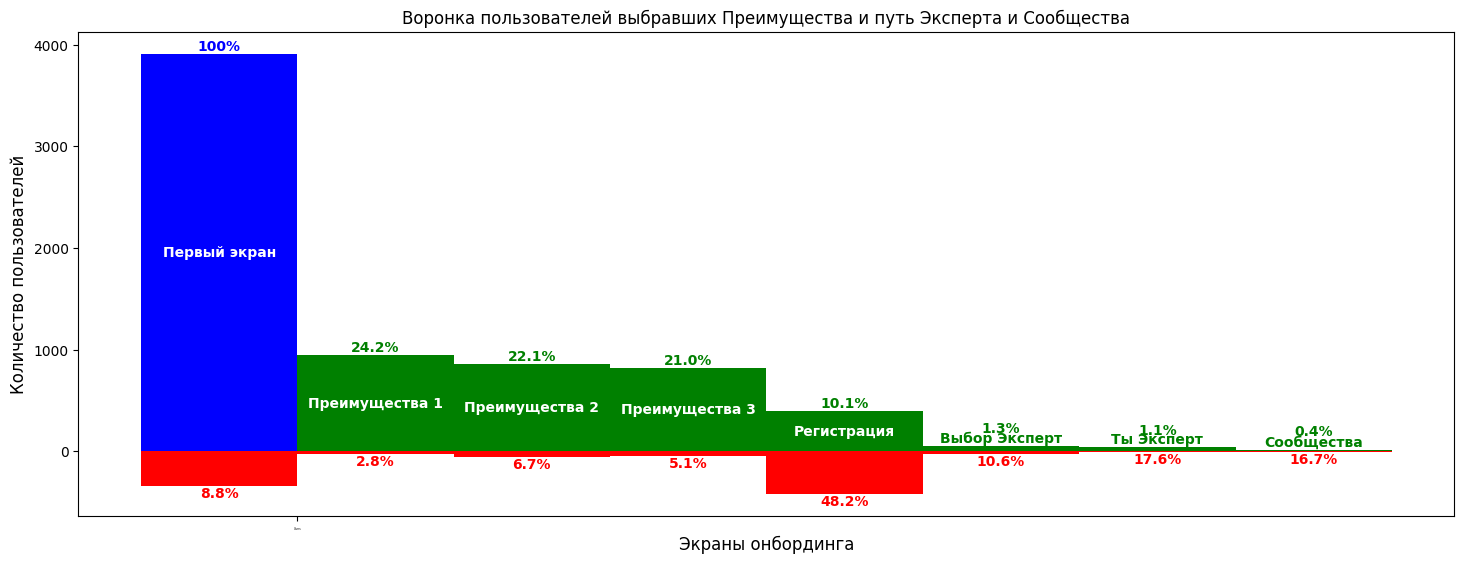

In [ ]:
#### ОТТОК ПРЕИМУЩЕСТВА

# 42
lost_view_hello = view_hello - (choose_hello_registration + choose_hello_features ) # отток индекс 1
lost_features_1 = choose_hello_features - view_features_1 # отток индекс 4
lost_features_2 = view_features_1 - view_features_2 # отток индекс 6
lost_features_3 = view_features_2 - view_features_3 # отток индекс 8
lost_registration_features = view_features_3 - view_discover_app_features # отток индекс 29
lost_role_way_features = choose_discover_app_explorer_features - (click_role_way_expert_features + click_role_way_explorer_features + click_role_way_both_role_features) # отток индекс 32
lost_click_expert_way_next_features = click_role_way_expert_features - click_expert_way_next_features # отток индекс 37
lost_click_expert_job_community = click_expert_way_next_features - (click_expert_job_community_features + click_expert_job_event_features) # отток индекс 40

# Рассчитываем проценты
choose_features_percent = ((choose_hello_features) / view_hello) * 100 #процент всех пользователей посмотревших индекс 1
lost_view_hello_percent = (lost_view_hello / view_hello) * 100 # процент оттока индекс 1

features_1_percent = ((view_features_1) / view_hello) * 100 # процент всех пользователей посмотревших индекс 4
lost_features_1_percent = (lost_features_1 / view_features_1) * 100 #процент оттока индекс 4

features_2_percent = ((view_features_2) / view_hello) * 100 # процент всех пользователей посмотревших индекс 6
lost_features_2_percent = (lost_features_2 / view_features_2) * 100 #процент оттока индекс 6

features_3_percent = ((view_features_3) / view_hello) * 100 # процент всех пользователей посмотревших индекс 8
lost_features_3_percent = (lost_features_3 / view_features_3) * 100 #процент оттока индекс 8

registration_features_percent = ((view_discover_app_features) / view_hello) * 100  # процент всех пользователей перешедших на индекс 29
lost_registration_features_percent = (view_discover_app_features / view_features_3) * 100 # процент оттока индекс 29

role_way_features_expert_percent = ((click_role_way_expert_features) / view_hello) * 100  # процент всех пользователей перешедших на индекс 32
lost_role_way_features_percent = (lost_role_way_features / choose_discover_app_explorer_features) * 100 # процент оттока индекс 32

click_expert_way_next_features_percent = ((click_expert_way_next_features) / view_hello) * 100  # процент всех пользователей перешедших на индекс 37
lost_click_expert_way_next_features_percent = (lost_click_expert_way_next_features / click_role_way_expert_features) * 100 # процент оттока индекс 37

click_expert_job_community_features_percent = ((click_expert_job_community_features) / view_hello) * 100  # процент всех пользователей перешедших на индекс 37
lost_click_expert_job_community_percent = (lost_click_expert_job_community / click_expert_way_next_features) * 100 # процент оттока индекс 40

# Создаём график
fig, ax = plt.subplots(figsize=(15, 6))

# Места для столбцов
bar_width = 0.1
index = [0]  # Местоположение для одного столбца

# Строим столбцы
view_hello_bar = ax.bar(index, view_hello, bar_width, label='view_hello (100%)', color='blue')  # Столбец view_hello
lost_view_hello_bar = ax.bar(index, -lost_view_hello, bar_width, label='lost_view_hello', color='red')  # Столбец lost_view_hello
choose_hello_features_bar = ax.bar([i+1 * bar_width for i in index], choose_hello_features, bar_width, label='choose_hello_features', color='green')  # Столбец features_1
lost_features_1_bar = ax.bar([i+1 * bar_width for i in index], -lost_features_1, bar_width, label='lost_features_1', color='red')  # Столбец lost_features_1 отток
view_features_2_bar = ax.bar([i+2 * bar_width for i in index], view_features_2, bar_width, label='view_features_2', color='green')  # Столбец view_features_2
lost_features_2_bar = ax.bar([i+2 * bar_width for i in index], -lost_features_2, bar_width, label='lost_features_2', color='red')  # Столбец lost_features_2 отток
view_features_3_bar = ax.bar([i+3 * bar_width for i in index], view_features_3, bar_width, label='view_features_2', color='green')  # Столбец view_features_3
lost_features_3_bar = ax.bar([i+3 * bar_width for i in index], -lost_features_3, bar_width, label='lost_features_2', color='red')  # Столбец lost_features_3 отток
registration_features_bar = ax.bar([i+4 * bar_width for i in index], view_discover_app_features, bar_width, label='view_features_2', color='green')  # Столбец registration_features
lost_registration_features_bar = ax.bar([i+4 * bar_width for i in index], -lost_registration_features, bar_width, label='lost_features_2', color='red')  # Столбец lost_registration_features отток
role_way_features_bar = ax.bar([i+5 * bar_width for i in index], click_role_way_expert_features, bar_width, label='view_features_2', color='green')  # Столбец role_way_features
lost_role_way_features_bar = ax.bar([i+5 * bar_width for i in index], -lost_role_way_features, bar_width, label='lost_features_2', color='red')  # Столбец lost_role_way_features отток
click_expert_way_next_features_bar = ax.bar([i+6 * bar_width for i in index], click_expert_way_next_features, bar_width, label='view_features_2', color='green')  # Столбец click_expert_way_next_features
lost_click_expert_way_next_features_bar = ax.bar([i+6 * bar_width for i in index], -lost_click_expert_way_next_features, bar_width, label='lost_features_2', color='red')  # Столбец lost_click_expert_way_next_features отток
click_expert_job_community_features_bar = ax.bar([i+7 * bar_width for i in index], click_expert_job_community_features, bar_width, label='view_features_2', color='green')  # Столбец click_expert_job_community_features
lost_click_expert_job_community_bar = ax.bar([i+7 * bar_width for i in index], -lost_click_expert_job_community, bar_width, label='lost_features_2', color='red')  # Столбец lost_click_expert_job_community отток

# Добавляем проценты и названия внутри каждого столбца
for i in index:
    # Добавляем текст view_hello
    ax.text(i, view_hello / 2, 'Первый экран', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для view_hello
    ax.text(i, view_hello + 5, f'100%', ha='center', va='bottom', color='blue', fontweight='bold', fontsize=10)

    # Процент отток для lost_view_hello
    ax.text(i, -lost_view_hello - 5, f'{lost_view_hello_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для choose_hello_features
    ax.text(i + 1 * bar_width, choose_hello_features / 2, 'Преимущества 1', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для choose_hello_features
    ax.text(i + 1 * bar_width, choose_hello_features + 5, f'{choose_features_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для lost_features_1
    ax.text(i + 1 * bar_width, -lost_features_1 - 5, f'{lost_features_1_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для view_features_2
    ax.text(i + 2 * bar_width, view_features_2 / 2, 'Преимущества 2', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для view_features_2
    ax.text(i + 2 * bar_width, view_features_2 + 5, f'{features_2_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для view_features_2
    ax.text(i + 2 * bar_width, -lost_features_2 - 5, f'{lost_features_2_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для view_features_3
    ax.text(i + 3 * bar_width, view_features_3 / 2, 'Преимущества 3', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для view_features_3
    ax.text(i + 3 * bar_width, view_features_3 + 5, f'{features_3_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для view_features_3
    ax.text(i + 3 * bar_width, -lost_features_3 - 5, f'{lost_features_3_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для view_discover_app_features
    ax.text(i + 4 * bar_width, view_discover_app_features / 2, 'Регистрация', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для view_discover_app_features
    ax.text(i + 4 * bar_width, view_discover_app_features + 5, f'{registration_features_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для view_discover_app_features
    ax.text(i + 4 * bar_width, -lost_registration_features - 5, f'{lost_registration_features_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для role_way_features_bar
    ax.text(i + 5 * bar_width, click_role_way_expert_features + 5 / 2, 'Выбор Эксперт', ha='center', va='bottom', color='green', fontsize=10, fontweight='bold')

    # Процент для role_way_features_bar
    ax.text(i + 5 * bar_width, click_role_way_expert_features + 100, f'{role_way_features_expert_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для view_discover_app_features
    ax.text(i + 5 * bar_width, -lost_role_way_features - 5, f'{lost_role_way_features_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для click_expert_way_next_features
    ax.text(i + 6 * bar_width, click_expert_way_next_features + 5 / 2, 'Ты Эксперт', ha='center', va='bottom', color='green', fontsize=10, fontweight='bold')

    # Процент для click_expert_way_next_features
    ax.text(i + 6 * bar_width, click_expert_way_next_features_percent + 130, f'{click_expert_way_next_features_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для lost_click_expert_way_next_features
    ax.text(i + 6 * bar_width, -lost_click_expert_way_next_features - 5, f'{lost_click_expert_way_next_features_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для click_expert_job_community_features
    ax.text(i + 7 * bar_width, click_expert_job_community_features + 5 / 2, 'Сообщества', ha='center', va='bottom', color='green', fontsize=10, fontweight='bold')

    # Процент для click_expert_job_community_features
    ax.text(i + 7 * bar_width, click_expert_job_community_features_percent + 120, f'{click_expert_job_community_features_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для lost_click_expert_job_community
    ax.text(i + 7 * bar_width, -lost_click_expert_job_community - 5, f'{lost_click_expert_job_community_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

# Настройка осей
ax.set_xlabel('Экраны онбординга', fontsize=12)  # Уменьшаем шрифт для оси X
ax.set_ylabel('Количество пользователей', fontsize=12)  # Уменьшаем шрифт для оси Y
ax.set_title('Воронка пользователей выбравших Преимущества и путь Эксперта и Сообщества', fontsize=12)  # Уменьшаем размер шрифта для заголовка

# Устанавливаем метки на оси X
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Users'], fontsize=2)

# Настройка tight_layout для автоматической подгонки
plt.tight_layout(pad=2.0)

# Показываем график
plt.show()

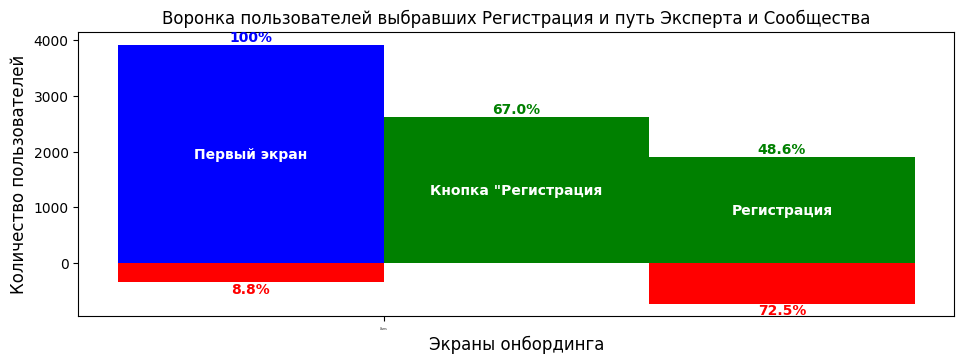

In [ ]:
#### ОТТОК РЕГИСТРАЦИЯ

# 43

lost_view_hello_reg = view_hello - (choose_hello_registration + choose_hello_features ) # отток индекс 1
lost_registration_reg = choose_hello_registration - view_discover_app_registration # отток индекс 29

# Рассчитываем проценты
lost_view_hello_percent = (lost_view_hello / view_hello) * 100 # процент оттока индекс 1
choose_hello_percent = ((choose_hello_registration) / view_hello) * 100 #процент всех пользователей посмотревших индекс 1
registration_registration_percent = ((view_discover_app_registration) / view_hello) * 100  # процент всех пользователей перешедших на индекс 29
lost_registration_registration_percent = (view_discover_app_registration / choose_hello_registration) * 100 # процент оттока индекс 29

# Создаём график
fig, ax = plt.subplots(figsize=(10, 4))

# Места для столбцов
bar_width = 0.1
index = [0]  # Местоположение для одного столбца

# Строим столбцы
view_hello_bar = ax.bar(index, view_hello, bar_width, label='view_hello (100%)', color='blue')  # Столбец view_hello
lost_view_hello_bar = ax.bar(index, -lost_view_hello_reg, bar_width, label='lost_view_hello', color='red')  # Столбец lost_view_hello
choose_hello_registration_bar = ax.bar([i+1 * bar_width for i in index], choose_hello_registration, bar_width, label='choose_hello_registration', color='green')  # Столбец features_1
registration_registration_bar = ax.bar([i+2 * bar_width for i in index], view_discover_app_registration, bar_width, label='view_discover_app_registration', color='green')  # Столбец features_1
lost_registration_registration_bar = ax.bar([i+2 * bar_width for i in index], -lost_registration_reg, bar_width, label='lost_registration_reg', color='red')  # Столбец features_1

# Добавляем проценты и названия внутри каждого столбца
for i in index:
    # Добавляем текст view_hello
    ax.text(i, view_hello / 2, 'Первый экран', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для view_hello
    ax.text(i, view_hello + 5, f'100%', ha='center', va='bottom', color='blue', fontweight='bold', fontsize=10)

    # Процент отток для lost_view_hello
    ax.text(i, -lost_view_hello - 5, f'{lost_view_hello_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)

    # Добавляем текст для choose_hello_registration
    ax.text(i + 1 * bar_width, choose_hello_registration / 2, 'Кнопка "Регистрация', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для choose_hello_registration
    ax.text(i + 1 * bar_width, choose_hello_registration + 5, f'{choose_hello_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Добавляем текст для choose_hello_registration_bar
    ax.text(i + 2 * bar_width, view_discover_app_registration / 2, 'Регистрация', ha='center', va='center', color='white', fontsize=10, fontweight='bold')

    # Процент для choose_hello_registration_bar
    ax.text(i + 2 * bar_width, view_discover_app_registration + 5, f'{registration_registration_percent:.1f}%', ha='center', va='bottom', color='green', fontweight='bold', fontsize=10)

    # Процент отток для lost_registration_reg
    ax.text(i + 2 * bar_width, -lost_registration_reg - 5, f'{lost_registration_registration_percent:.1f}%', ha='center', va='top', color='red', fontweight='bold', fontsize=10)


# Настройка осей
ax.set_xlabel('Экраны онбординга', fontsize=12)  # Уменьшаем шрифт для оси X
ax.set_ylabel('Количество пользователей', fontsize=12)  # Уменьшаем шрифт для оси Y
ax.set_title('Воронка пользователей выбравших Регистрация и путь Эксперта и Сообщества', fontsize=12)  # Уменьшаем размер шрифта для заголовка

# Устанавливаем метки на оси X
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(['Users'], fontsize=2)

# Настройка tight_layout для автоматической подгонки
plt.tight_layout(pad=2.0)

# Показываем график
plt.show()

In [ ]:
# 43# only_profile_id = choose_discover_app_go_registration_tab.copy()
# #1: Создадим список с форматированными значениями из столбца profile_id
# formatted_values = [
#     f'"{value}",' if i < len(only_profile_id['profile_id']) - 1 else f'"{value}"'
#     for i, value in enumerate(only_profile_id['profile_id'].astype(str))
# ]

# #2: Сохранение в текстовый файл
# with open("only_profile_id_discover_app_go_registration.txt", "w") as file:
#     file.write("\n".join(formatted_values))

# #3: Скачаем
# from google.colab import files
# files.download("only_profile_id_discover_app_go_registration.txt")

Данные по полной выборке:

Различия в распределении статистически значимы! Нет оснований делать вывод о том, что выборки похожи.
Распределения статусов в выборке различны.
8.249428149149186e-21

Эффект Крамера: 0.2604
Небольшое различие в выборках


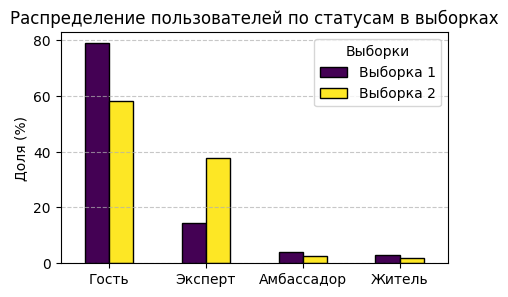

Данные по выборке без Экспертов:

Статистически значимых различий нет. Есть основания сделать вывод, что выборки похожи.

Эффект Крамера: 0.0212
Различие очень слабое в выборках


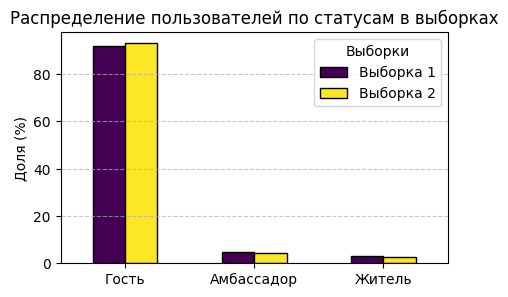

In [ ]:
# 43 Проверим, есть ли статистически значимые различия в распределении статусов внутри выборок
# Различается ли распределение статусов

# Выборка 1 — не прошли онбординг
# Выборка 2 — прошли онбординг

# Сформулируем гипотезу

# Исхожу из того, что данные категориальны, количество наблюдений достаточно (>= 5) и кол-во пользователей в выборках различается, а такжераспределение не сбалансированно
# Применим тест хи-квадрат и в дальнейшем рассмотрим мера величины эффекта (значение V Крамера), нулевая гипотеза в тесте хи-квадрат — отсутствие связи

# Сформулируем нулевую и альтернативную гипотезы для теста хи-квадрат

# Нулевая гипотеза (H0) — распределение статусов не отличается между выборками (т.е распределение статусов пользователей не зависит от выборки) / Отсутствие различий в пропорциях сдеалал/не сделал в выборках

# Альтернативная гипотеза (H1) — распределение статусов имеют различия (т.е в одной выборке где-то различия, например, больше пользователей одного статуса, чем в другой) / Есть различия в пропорциях

# Это необходимо сделать ("сравнить выборки"), чтобы в следующем шаге изменения связаны именно с фактором прохождения/не прохождения онбординга, а не с разницей в выборках

#

# 43.1 Сформируем датафрейм для работы, таблицу сопряженности
data_all = pd.DataFrame({
          "Выборка 1": [482, 87, 25, 17],
          "Выборка 2": [472, 307, 21, 14]
          }, index=["Гость", "Эксперт", "Амбассадор", "Житель"])

# 43.2 Применим Тест ХИ-хвадрат

# Почему

p_value = stats.chi2_contingency(data_all)[1]

if p_value < 0.05:
    print("Данные по полной выборке:")
    print()
    print("Различия в распределении статистически значимы! Нет оснований делать вывод о том, что выборки похожи.")
    print("Распределения статусов в выборке различны.")
    print(p_value)
    print()
else:
    print("Данные по полной выборке")
    print()
    print("Статистически значимых различий нет. Есть основания сделать вывод, что выборки похожи.")
    print()

# 43.3 Оценим эффект Крамера, посмотрим, есть ли статистически значимая связь между статусом пользователя и прохождением / не прохождением онбординга (т.е некая "сила" связи)

chi2_stat, p_value, _, _ = stats.chi2_contingency(data_all)

# Подготовим переменные для рассчета
n = data_all.to_numpy().sum()  # Общее число наблюдений
v = np.sqrt(chi2_stat / (n * (min(data_all.shape) - 1)))

# Выведем результат
print(f"Эффект Крамера: {v:.4f}")

if v > 0.5:
    print("Сильное различие в выборках")
elif v > 0.3:
    print("Среднее различие в выборках")
elif v > 0.1:
    print("Небольшое различие в выборках")
else:
    print("Различие очень слабое в выборках")

# 43.4 Построим График

percent_data = data_all.div(data_all.sum(axis=0), axis=1) * 100

# Визуализируем
percent_data.plot(kind="bar", figsize=(5, 3), colormap="viridis", edgecolor="black")
plt.title("Распределение пользователей по статусам в выборках")
plt.ylabel("Доля (%)")
plt.xticks(rotation=0)
plt.legend(title="Выборки")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# 44  Посмотрим, как поведут себя значения, если уберем пользователей со статусом "Эксперт"

# 44.1 Сформируем датафрейм для работы
data_without = pd.DataFrame({
               "Выборка 1": [482, 25, 17],
               "Выборка 2": [472, 21, 14]
               }, index=["Гость", "Амбассадор", "Житель"])

# 44.2 Применим Тест ХИ-хвадрат

p_value = stats.chi2_contingency(data_without)[1]

if p_value < 0.05:
    print("Данные по выборке без Экспертов:")
    print()
    print("Различия в распределении статистически значимы! Нет оснований делать вывод о том, что выборки похожи.")
    print("Распределения статусов в выборке различны.")
    print(p_value)
    print()
else:
    print("Данные по выборке без Экспертов:")
    print()
    print("Статистически значимых различий нет. Есть основания сделать вывод, что выборки похожи.")
    print()

# 44.3 Оценим эффект Крамера, посмотрим, есть ли статистически значимая связь между статусом пользователя и прохождением / не прохождением онбординга

chi2_stat, p_value, _, _ = stats.chi2_contingency(data_without)

# Подготовим переменные для рассчета
n = data_without.to_numpy().sum()  # Общее число наблюдений
v = np.sqrt(chi2_stat / (n * (min(data_without.shape) - 1)))

# Выведем результат
print(f"Эффект Крамера: {v:.4f}")

if v > 0.5:
    print("Сильное различие в выборках")
elif v > 0.3:
    print("Среднее различие в выборках")
elif v > 0.1:
    print("Небольшое различие в выборках")
else:
    print("Различие очень слабое в выборках")

# 44.4 Построим График

percent_data = data_without.div(data_without.sum(axis=0), axis=1) * 100

# Визуализируем
percent_data.plot(kind="bar", figsize=(5, 3), colormap="viridis", edgecolor="black")
plt.title("Распределение пользователей по статусам в выборках")
plt.ylabel("Доля (%)")
plt.xticks(rotation=0)
plt.legend(title="Выборки")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()



In [ ]:
# 45 Проверим, есть ли статистически значимые различия в размещении поста пользователей двух выборок
# Различается ли активность пользователей

# Сформулировать гипотезу

data = pd.DataFrame({
    'Разместили пост': [70, 98],
    'Не разместили пост': [539, 714]
}, index=["Выборка 1", "Выборка 2"])

# Условия для проедения теста хи-квадрат выполнены

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
if p_value < 0.05:
    print()
    print("Размещение постов:")
    print("Различия в распределении статистически значимы! Есть различия в размещении постов.")
else:
    print()
    print("Размещение постов:")
    print("Различий нет. Распределение по размещению постов похоже.")

# 46 Проверим, есть ли статистически значимые различия в бронирование пользователей двух выборок

# Сформируем датафрейм для работы, таблицу сопряженности
data = pd.DataFrame({
    'Забронировали': [31, 53],
    'Не забронировали': [578, 759]
}, index=["Выборка 1", "Выборка 2"])

# Сформулируем нулевую и альтернативную гипотезы для теста хи-квадрат

# Нулевая гипотеза (H0) — распределение (как часто встречаются такие) пользователей, забронировавших участие в мероприятии не отличается между выборками
# Альтернативная гипотеза (H1) — распределение пользователей, забронировавших участие в мероприятии имеют различия

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
if p_value < 0.05:
    print()
    print("Бронирование:")
    print("Различия в распределении статистически значимы! Есть различия в бронировании.")
else:
    print()
    print("Бронирование:")
    print("Различий нет. Распределение по бронированию похоже.")

# 47 Проверим, есть ли статистически значимые различия в комментарий пользователей двух выборок

data = pd.DataFrame({
    'Комментарий': [22, 35],
    'Без комментария': [587, 777]
}, index=["Выборка 1", "Выборка 2"])

# Сформулируем нулевую и альтернативную гипотезы для теста хи-квадрат

# Нулевая гипотеза (H0) — распределение (как часто встречаются такие) пользователей, оставивших комментарий не отличается между выборками
# Альтернативная гипотеза (H1) — распределение пользователей, оставивших комментарий имеют различия

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
if p_value < 0.05:
    print()
    print("Комментарии:")
    print("Различия в распределении статистически значимы! Есть различия в комментариях.")
else:
    print()
    print("Комментарии:")
    print("Различий нет. Распределение по комментариям похоже.")

# 48 Проверим, есть ли статистически значимые различия в лайк пользователей двух выборок

data = pd.DataFrame({
    'Лайк': [400, 478],
    'Без лайка': [209, 334]
}, index=["Выборка 1", "Выборка 2"])

# Сформулируем нулевую и альтернативную гипотезы для теста хи-квадрат

# Нулевая гипотеза (H0) — распределение (как часто встречаются такие) пользователей, оставивших лайк не отличается между выборками
# Альтернативная гипотеза (H1) — распределение пользователей, оставивших лайк имеют различия

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
if p_value < 0.05:
    print()
    print("Лайки:")
    print("Различия в распределении статистически значимы! Есть различия в лайках.")
else:
    print()
    print("Лайки:")
    print("Различий нет. Распределение по лайкам похоже.")

# 49 Проверим, есть ли статистически значимые различия в пост в круге пользователей двух выборок

# Сформулируем нулевую и альтернативную гипотезы для теста хи-квадрат

# Нулевая гипотеза (H0) — распределение (как часто встречаются такие) пользователей, оставивших пост в круге не отличается между выборками
# Альтернативная гипотеза (H1) — распределение пользователей, пост в круге имеют различия

data = pd.DataFrame({
    'Пост в круге': [8, 11],
    'Без поста в круге': [601, 801]
}, index=["Выборка 1", "Выборка 2"])

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
if p_value < 0.05:
    print()
    print("Пост в Круге:")
    print("Различия в распределении статистически значимы! Есть различия в постах в круге.")
else:
    print()
    print("Пост в Круге:")
    print("Различий нет. Распределение по постам в круге похоже.")

# 50 Проверим, есть ли статистически значимые различия в вступлении в круг пользователей двух выборок

data = pd.DataFrame({
    'Вступление в Круг': [204, 337],
    'Без вступления': [405, 475]
}, index=["Выборка 1", "Выборка 2"])

# Сформулируем нулевую и альтернативную гипотезы для теста хи-квадрат

# Нулевая гипотеза (H0) — распределение (как часто встречаются такие) пользователей, вступивших в круг не отличается между выборками
# Альтернативная гипотеза (H1) — распределение пользователей, вступивших в круг имеют различия

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
if p_value < 0.05:
    print()
    print("Вступление в Круг:")
    print("Различия в распределении статистически значимы! Есть различия во вступлении в круг.")
else:
    print()
    print("Вступление в Круг:")
    print("Различий нет. Распределение по постам во вступлении в круг.")


Размещение постов:
Различий нет. Распределение по размещению постов похоже.

Бронирование:
Различий нет. Распределение по бронированию похоже.

Комментарии:
Различий нет. Распределение по комментариям похоже.

Лайки:
Различия в распределении статистически значимы! Есть различия в лайках.

Пост в Круге:
Различий нет. Распределение по постам в круге похоже.

Вступление в Круг:
Различия в распределении статистически значимы! Есть различия во вступлении в круг.


In [ ]:
def calculate_cramer_v(chi2_stat, data):
    # Составим функцию для расчета эффекта Крамера
    n = data.to_numpy().sum()  # Общее число наблюдений
    v = np.sqrt(chi2_stat / (n * (min(data.shape) - 1)))  # Формула для эффекта Крамера
    return v

# 45 Проверим, есть ли статистически значимые различия в размещении поста пользователей двух выборок
data = pd.DataFrame({
    'Разместили пост': [70, 98],
    'Не разместили пост': [539, 714]
}, index=["Выборка 1", "Выборка 2"])

# Условия для проедения теста хи-квадрат выполнены

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
print("Размещение постов:")
if p_value < 0.05:
    print("Различия в распределении статистически значимы! Есть различия в размещении постов.")
else:
    print("Различий нет. Распределение по размещению постов похоже.")

# Оценка эффекта Крамера
v = calculate_cramer_v(chi2_stat, data)
print(f"Эффект Крамера: {v:.4f}")
if v > 0.5:
    print("Сильное различие в выборках.")
elif v > 0.3:
    print("Среднее различие в выборках.")
elif v > 0.1:
    print("Небольшое различие в выборках.")
else:
    print("Различие очень слабое в выборках.")

# 46 Проверим, есть ли статистически значимы различия в бронировании пользователей двух выборок
data = pd.DataFrame({
    'Забронировали': [31, 53],
    'Не забронировали': [578, 759]
}, index=["Выборка 1", "Выборка 2"])

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
print("\nБронирование:")
if p_value < 0.05:
    print("Различия в распределении статистически значимы! Есть различия в бронировании.")
else:
    print("Различий нет. Распределение по бронированию похоже.")

# Оценка эффекта Крамера
v = calculate_cramer_v(chi2_stat, data)
print(f"Эффект Крамера: {v:.4f}")
if v > 0.5:
    print("Сильное различие в выборках.")
elif v > 0.3:
    print("Среднее различие в выборках.")
elif v > 0.1:
    print("Небольшое различие в выборках.")
else:
    print("Различие очень слабое в выборках.")

# 47 Проверим, есть ли статистически значимы различия в комментариях пользователей двух выборок
data = pd.DataFrame({
    'Комментарий': [22, 35],
    'Без комментария': [587, 777]
}, index=["Выборка 1", "Выборка 2"])

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
print("\nКомментарии:")
if p_value < 0.05:
    print("Различия в распределении статистически значимы! Есть различия в комментариях.")
else:
    print("Различий нет. Распределение по комментариям похоже.")

# Оценка эффекта Крамера
v = calculate_cramer_v(chi2_stat, data)
print(f"Эффект Крамера: {v:.4f}")
if v > 0.5:
    print("Сильное различие в выборках.")
elif v > 0.3:
    print("Среднее различие в выборках.")
elif v > 0.1:
    print("Небольшое различие в выборках.")
else:
    print("Различие очень слабое в выборках.")

# 48 Проверим, есть ли статистически значимы различия в лайках пользователей двух выборок
data = pd.DataFrame({
    'Лайк': [400, 478],
    'Без лайка': [209, 334]
}, index=["Выборка 1", "Выборка 2"])

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
print("\nЛайки:")
if p_value < 0.05:
    print("Различия в распределении статистически значимы! Есть различия в лайках.")
else:
    print("Различий нет. Распределение по лайкам похоже.")

# Оценка эффекта Крамера
v = calculate_cramer_v(chi2_stat, data)
print(f"Эффект Крамера: {v:.4f}")
if v > 0.5:
    print("Сильное различие в выборках.")
elif v > 0.3:
    print("Среднее различие в выборках.")
elif v > 0.1:
    print("Небольшое различие в выборках.")
else:
    print("Различие очень слабое в выборках.")

# 49 Проверим, есть ли статистически значимы различия в постах в круге пользователей двух выборок
data = pd.DataFrame({
    'Пост в круге': [8, 11],
    'Без поста в круге': [601, 801]
}, index=["Выборка 1", "Выборка 2"])

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
print("\nПост в Круге:")
if p_value < 0.05:
    print("Различия в распределении статистически значимы! Есть различия в постах в круге.")
else:
    print("Различий нет. Распределение по постам в круге похоже.")

# Оценка эффекта Крамера
v = calculate_cramer_v(chi2_stat, data)
print(f"Эффект Крамера: {v:.4f}")
if v > 0.5:
    print("Сильное различие в выборках.")
elif v > 0.3:
    print("Среднее различие в выборках.")
elif v > 0.1:
    print("Небольшое различие в выборках.")
else:
    print("Различие очень слабое в выборках.")

# 50 Проверим, есть ли статистически значимы различия во вступлении в круг пользователей двух выборок
data = pd.DataFrame({
    'Вступление в Круг': [204, 337],
    'Без вступления': [405, 475]
}, index=["Выборка 1", "Выборка 2"])

# Хи-квадрат тест
chi2_stat, p_value, _, _ = stats.chi2_contingency(data)

# Вывод результата
print("\nВступление в Круг:")
if p_value < 0.05:
    print("Различия в распределении статистически значимы! Есть различия во вступлении в круг.")
else:
    print("Различий нет. Распределение по постам во вступлении в круг.")

# Оценка эффекта Крамера
v = calculate_cramer_v(chi2_stat, data)
print(f"Эффект Крамера: {v:.4f}")
if v > 0.5:
    print("Сильное различие в выборках.")
elif v > 0.3:
    print("Среднее различие в выборках.")
elif v > 0.1:
    print("Небольшое различие в выборках.")
else:
    print("Различие очень слабое в выборках.")


Размещение постов:
Различий нет. Распределение по размещению постов похоже.
Эффект Крамера: 0.0066
Различие очень слабое в выборках.

Бронирование:
Различий нет. Распределение по бронированию похоже.
Эффект Крамера: 0.0271
Различие очень слабое в выборках.

Комментарии:
Различий нет. Распределение по комментариям похоже.
Эффект Крамера: 0.0140
Различие очень слабое в выборках.

Лайки:
Различия в распределении статистически значимы! Есть различия в лайках.
Эффект Крамера: 0.0679
Различие очень слабое в выборках.

Пост в Круге:
Различий нет. Распределение по постам в круге похоже.
Эффект Крамера: 0.0000
Различие очень слабое в выборках.

Вступление в Круг:
Различия в распределении статистически значимы! Есть различия во вступлении в круг.
Эффект Крамера: 0.0801
Различие очень слабое в выборках.
